# Complete Workflow

This workflow provides a complete working example to develop an unstructured mesh for an integrated hydrologic model based on HUCs.  It is the default workflow for integrated hydrology simulations for Exasheds Simulation Campaign 2.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

Given some basic inputs (in the next cell) including a NAME, this workflow creates the following files (noting that some suffixes may be appended to the user-provided NAME in homogeneous cases):

* Mesh file: `{NAME}.exo`, includes all labeled sets
* Forcing: DayMet data -- daily raster of precip, RH, incoming radiation, etc.
  - `{NAME}_DayMet_1980_2022.h5`, the DayMet data on this watershed
  - `{NAME}_DayMet_typical_1980_2022.h5`, a "typical year" of DayMet, smoothed for spinup purposes, then looped 40 years
* Forcing: LAI data -- every 4 days, time series by land cover type of LAI.  Note, the raw inputs to this are not done by NAME, but by an (optional, defaults to NAME) MODIS_NAME variable.  Since WW does not currently download MODIS, one might want to use a file of a different name to provide MODIS data.  The times of this MODIS data are hard-coded too -- this is all a bit wonky and will remain so until we get around to adding a file manager for MODIS data.
  - `{NAME}_MODIS_LAI_smoothed_2002_2022.h5`, the LAI, interpolated and smoothed from the raw MODIS data
  - `{NAME}_MODIS_LAI_typical_1980_2022.h5`, a "typical year" of LAI, smoothed for spinup purposes then looped 40 years
* Input files: ATS xml files
  - `spinup-steadystate-{NAME}.xml` the steady-state solution based on uniform application of mean rainfall rate
  - `spinup-cyclic_steadystate-{NAME}.xml` the cyclic steady state based on typical years
  - `transient-{NAME}.xml` the forward model


In [1]:
# these can be turned on for development work
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
name = 'OakMixed' # name the domain, used in filenames, etc
hucs = ['170300020307'] # a list of HUCs to run
def get_huc12(hucs):
    huc12_list = []
    for huc in hucs:
        if len(huc) == 12:
            huc12_list.append(huc)
        elif len(huc) == 10:
            for i in range(1,20):
                huc12_list.append(huc+str(i).zfill(2))
        elif len(huc) == 8:
            for i in range(1,20):
                for j in range(1,20):
                    huc12_list.append(huc+str(i).zfill(2)+str(j).zfill(2))
        else:
            print('need huc8, huc10 or huc12')
    return huc12_list
hucs = get_huc12(hucs)
print(hucs[:10])

['170300020307']


In [119]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries

# geometric parameters
simplify_hucs = 10 # length scale to target average edge
simplify_rivers = 10
stream_outlet_width = 100 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.005 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating

# simulation control
start_year = 1980  # year to start and end simulation simulation -- note these start and end Oct 1 of the year
end_year = 2023
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

# triangle refinement control
include_rivers = True
# refine_d0 = 100
# refine_d1 = 500
# refine_A0 = 8000
# refine_A1 = 50000
# meshsize = 300
# factor = 1
# refine_d0 = meshsize*3
# refine_A0 = meshsize**2/2
# refine_d1 = meshsize*15
# refine_A1 = (np.round(meshsize*factor))**2/2

# soil structure
use_geologic_layer = True

# logistics
generate_plots = True # plots take time to make and aren't always needed
generate_daymet = True # potentially don't do Met data forcing
generate_modis = True

include_heterogeneous = True
include_homogeneous = False # if true, also write files for homogeneous runs
include_homogeneous_wrm = False # if true, also write files for homogeneous WRMs
include_homogeneous_wrm_porosity = False # if true, also write files for homogeneous porosity and WRMs
include_homogeneous_wrm_permeability = False # if true, also write files for homogeneous perm and WRMs

log_to_file = False  # if true, write to file instead of in the notebook output
figsize = (6,6)
figsize_3d = (8,6)

In [4]:
# parameter checking
# assert(simplify_hucs > 0 and simplify_hucs < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
# assert(start_year >= 1980 and start_year < 2022)

if type(hucs) is str:
    assert(hucs[0] == '[')
    assert(hucs[-1] == ']')
    hucs = hucs[1:-1]
    hucs = hucs.split(',')
    hucs = [h.strip() for h in hucs]
    if hucs[-1] == '':
        hucs = hucs[:-1]

if huc_level is None:
    huc_level = len(hucs[0])
else:
    assert(huc_level >= len(hucs[0]))
huc_key = f'HUC{huc_level}'

if prune_by_area_fraction_waterbodies is None:
    prune_by_area_fraction_waterbodies = prune_by_area_fraction * 0.1

In [5]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [6]:
import os
import sys
import copy
import logging
import numpy as np
import scipy.ndimage
from matplotlib import pyplot as plt
import pandas
import h5py
import shapely
import fiona
from shapely.geometry import mapping

# Watershed Workflow
import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.soil_properties
import watershed_workflow.daymet
import watershed_workflow.utils

import watershed_workflow.regions
import watershed_workflow.densification
import watershed_workflow.condition

if log_to_file:
    outputs['logfile'] = f'{name}.log'
    # is this right?  the file handle will become stale... test once this is pipelined.
    with open(outputs['logfile'], 'w') as fid:
        watershed_workflow.ui.setup_logging(1,fid)
else:
    watershed_workflow.ui.setup_logging(1,None)

# ats_input_spec library, to be moved to amanzi_xml
import ats_input_spec
import ats_input_spec.public
import ats_input_spec.io

# amanzi_xml, included in AMANZI_SRC_DIR/tools/amanzi_xml
import amanzi_xml.utils.io as aio
import amanzi_xml.utils.search as asearch
import amanzi_xml.utils.errors as aerrors


plt.rcParams['figure.dpi'] = 200
pandas.options.display.max_columns = None
pandas.options.display.max_rows = 20

ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/l/lizh142/.conda/envs/atsww/share/proj failed


In [7]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()
crs

<Derived Projected CRS: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=- ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [8]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)

2024-11-25 22:24:35,471 - root - INFO: 
2024-11-25 22:24:35,472 - root - INFO: Meshing shape: ['170300020307']
2024-11-25 22:24:35,472 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [9]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS('/global/cfs/cdirs/m1800/zhi/ww/scripts/data/soil_structure/GLHYMPS/GLHYMPS.shp')
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('/global/cfs/cdirs/m1800/zhi/ww/scripts/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif')
watershed_workflow.source_list.log_sources(sources)

2024-11-25 22:24:35,593 - root - INFO: Using sources:
2024-11-25 22:24:35,594 - root - INFO: --------------
2024-11-25 22:24:35,594 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-11-25 22:24:35,595 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-11-25 22:24:35,595 - root - INFO: DEM: National Elevation Dataset (NED)
2024-11-25 22:24:35,596 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2024-11-25 22:24:35,596 - root - INFO: geologic structure: /global/cfs/cdirs/m1800/zhi/ww/scripts/data/soil_structure/GLHYMPS/GLHYMPS.shp
2024-11-25 22:24:35,597 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2019_Land_Cover_L48
2024-11-25 22:24:35,597 - root - INFO: lai: MODIS
2024-11-25 22:24:35,597 - root - INFO: depth to bedrock: raster
2024-11-25 22:24:35,598 - root - INFO: meteorology: DayMet 1km


In [10]:
# load the huc
my_hucs = []
for huc in hucs:
    _, ws = watershed_workflow.get_hucs(sources['HUC'], huc, huc_level, crs)
    my_hucs.extend(ws)

watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

2024-11-25 22:24:50,277 - root - INFO: 
2024-11-25 22:24:50,278 - root - INFO: Loading level 12 HUCs in 170300020307
2024-11-25 22:24:50,279 - root - INFO: ------------------------------
2024-11-25 22:24:50,311 - root - INFO: Using HUC file "/global/cfs/cdirs/m1800/zhi/ww/scripts/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2024-11-25 22:24:50,648 - root - INFO: ... found 1 HUCs
2024-11-25 22:24:50,648 - root - INFO:   -- 170300020307
2024-11-25 22:24:50,650 - root - INFO: Converting to out_crs
2024-11-25 22:24:50,659 - root - INFO: Converting to shapely
2024-11-25 22:24:50,661 - root - INFO:  ... done
2024-11-25 22:24:50,662 - root - INFO: Removing holes on 1 polygons
2024-11-25 22:24:50,662 - root - INFO:   -- removed interior
2024-11-25 22:24:50,664 - root - INFO:   -- union
2024-11-25 22:24:50,665 - root - INFO: Parsing 1 components for holes
2024-11-25 22:24:50,665 - root - INFO:   -- complete


In [11]:
### save watershed boundary shapefile
try:
    os.mkdir(f'../data-processed/{name}')
except FileExistsError:
    pass
try:
    os.mkdir(f'../images/{name}')
except FileExistsError:
    pass
outputs['watershed_shapefile_filename'] = f'../data-processed/{name}/{name}_bounds.shp'
# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open(outputs['watershed_shapefile_filename'], 'w', 'ESRI Shapefile', schema, crs=watershed_workflow.crs.to_fiona(crs)) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(watershed.exterior()),
        'properties': {'id': 123},
    })

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [12]:
if include_rivers:  
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], huc, 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True)
    
    rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
                                                 ignore_small_rivers=ignore_small_rivers,
                                                 prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                                 remove_diversions=True,
                                                 remove_braided_divergences=True)
else:
    reaches = []
    rivers = []

2024-11-25 22:24:58,485 - root - INFO: 
2024-11-25 22:24:58,486 - root - INFO: Loading Hydrography
2024-11-25 22:24:58,486 - root - INFO: ------------------------------
2024-11-25 22:24:58,487 - root - INFO: Loading streams in HUC 170300020307
2024-11-25 22:24:58,488 - root - INFO:          and/or bounds (-1521842.222472111, 636170.9978430516, -1503991.3075505565, 643495.1460236416)
2024-11-25 22:24:58,489 - root - INFO:   Using Hydrography file "/global/cfs/cdirs/m1800/zhi/ww/scripts/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2024-11-25 22:24:58,489 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/global/cfs/cdirs/m1800/zhi/ww/scripts/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb' layer 'NHDFlowline' for streams in '(-1521842.222472111, 636170.9978430516, -1503991.3075505565, 643495.1460236416)'
2024-11-25 22:24:59,759 - root - INFO:   Found total of 972 in bounds.
2024-11-25 22:24:59,760 - root - INFO: Filtering reaches 

In [13]:
# what about the reservoir!
_, waterbodies = watershed_workflow.get_waterbodies(sources['hydrography'], huc, watershed.exterior(), crs, crs, 
                                                    prune_by_area=prune_by_area_fraction_waterbodies*watershed.exterior().area)

2024-11-25 22:25:04,984 - root - INFO: 
2024-11-25 22:25:04,984 - root - INFO: Loading Water Bodies
2024-11-25 22:25:04,985 - root - INFO: ------------------------------
2024-11-25 22:25:04,985 - root - INFO: Loading waterbodies in HUC 170300020307
2024-11-25 22:25:04,986 - root - INFO:          and/or bounds (-1521842.222472111, 636170.9978430516, -1503991.3075505565, 643495.1460236416)
2024-11-25 22:25:04,987 - root - INFO:   Using Hydrography file "/global/cfs/cdirs/m1800/zhi/ww/scripts/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2024-11-25 22:25:04,988 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/global/cfs/cdirs/m1800/zhi/ww/scripts/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb' layer 'NHDWaterbody' for streams in '(-1521842.222472111, 636170.9978430516, -1503991.3075505565, 643495.1460236416)'
2024-11-25 22:25:05,111 - root - INFO:   Found total of 23 in bounds.
2024-11-25 22:25:05,111 - root - INFO: ... found 23 

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-descr

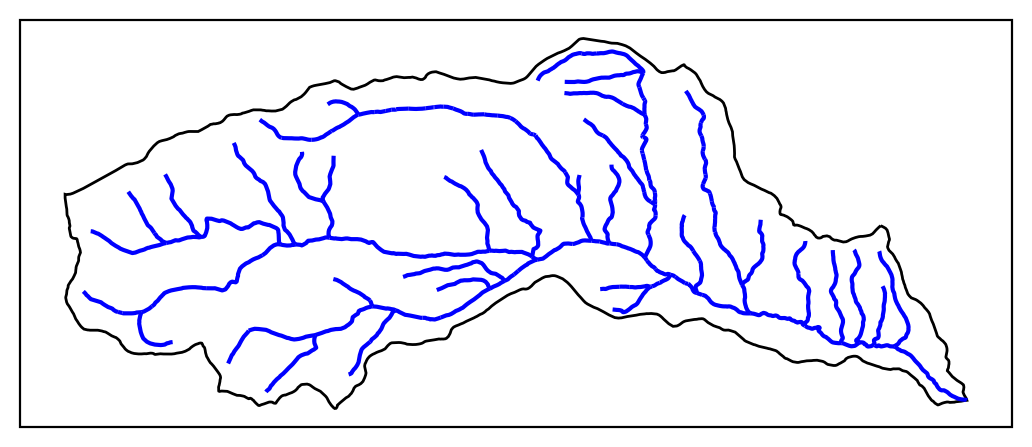

1


In [14]:
if generate_plots:
    fig, ax = watershed_workflow.plot.get_ax(crs)
    watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
    watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
    watershed_workflow.plot.shplys(waterbodies, crs, 'g', ax, facecolor='c')
    plt.show()
print(len(rivers))

In [15]:
# tol = 1e1
# keeping the originals
rivers_orig=[river.deepcopy() for river in rivers]
watershed_orig=copy.deepcopy(watershed) 

# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, 
                                     simplify_hucs=simplify_hucs, 
                                     simplify_rivers=simplify_rivers, 
                                     # prune_tol=tol, merge_tol=tol, snap_tol=tol,  # snap_tol=simplify_rivers*0.5, merge_tol=simplify_rivers*0.7,
                                     cut_intersections=False)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

print('number of reaches in original', len(rivers_orig[0]), 'number of reaches in simplified', len(rivers[0]))

2024-11-25 22:25:14,497 - root - INFO: 
2024-11-25 22:25:14,497 - root - INFO: Simplifying
2024-11-25 22:25:14,498 - root - INFO: ------------------------------
2024-11-25 22:25:14,498 - root - INFO: Simplifying rivers
2024-11-25 22:25:14,517 - root - INFO:   ...cleaned inner segment of length 5.99799 at centroid (-1510410.1482261855, 641216.6958549835) with id '55001000011272'
2024-11-25 22:25:14,522 - root - INFO: Simplifying HUCs
2024-11-25 22:25:14,524 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-11-25 22:25:14,528 - root - INFO:   snapping polygon segment boundaries to river endpoints
2024-11-25 22:25:14,535 - root - INFO:   snapping river endpoints to the polygon
2024-11-25 22:25:14,537 - root - INFO:   - snapped river: (-1503991.228432128, 636333.4720026184) to (-1503991.4491969836, 636333.3644187843)
2024-11-25 22:25:14,694 - root - INFO: 
2024-11-25 22:25:14,694 - root - INFO: Simplification Diagnostics
2024-11-25 22:25:14,695 - root - INFO: -----------

number of reaches in original 159 number of reaches in simplified 158


/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-descr

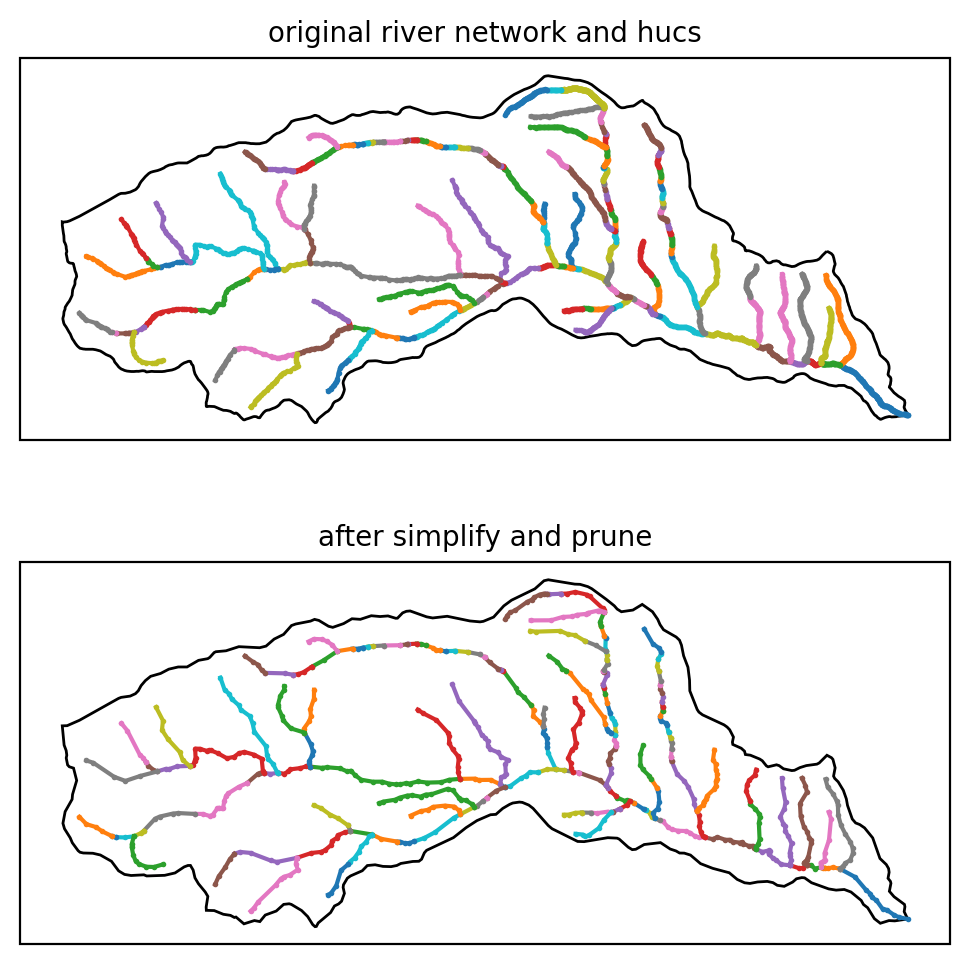

In [16]:
fig, axs = plt.subplots(2,1,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=figsize)
watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('original river network and hucs',fontsize=10)
watershed_workflow.plot.hucs(watershed_simplified, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=10)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=1)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=1)
        
plt.show()

In [17]:
meshsize = 30
factor = 3

near_distance = meshsize/2
far_distance = meshsize
near_length_scale = meshsize
far_length_scale = meshsize*factor

limit_scales = [near_distance, near_length_scale, far_distance, far_length_scale]

angle_limit = 20
junction_angle_limit = 20
huc_seg_river_angle_limit = 20

In [18]:
# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=limit_scales) 

#densify_river
watershed_workflow.densification.densify_rivers(rivers, rivers_orig, limit=meshsize)

# treat sharp angles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, 
                                                     # angle_limit=angle_limit, 
                                                     # junction_angle_limit=junction_angle_limit, 
                                                     # huc_seg_river_angle_limit=huc_seg_river_angle_limit, 
                                                     limit=meshsize)

2024-11-25 22:25:37,315 - root - INFO:   river min seg length: 14.366645112158503
2024-11-25 22:25:37,316 - root - INFO:   river median seg length: 24.409652942679656


/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


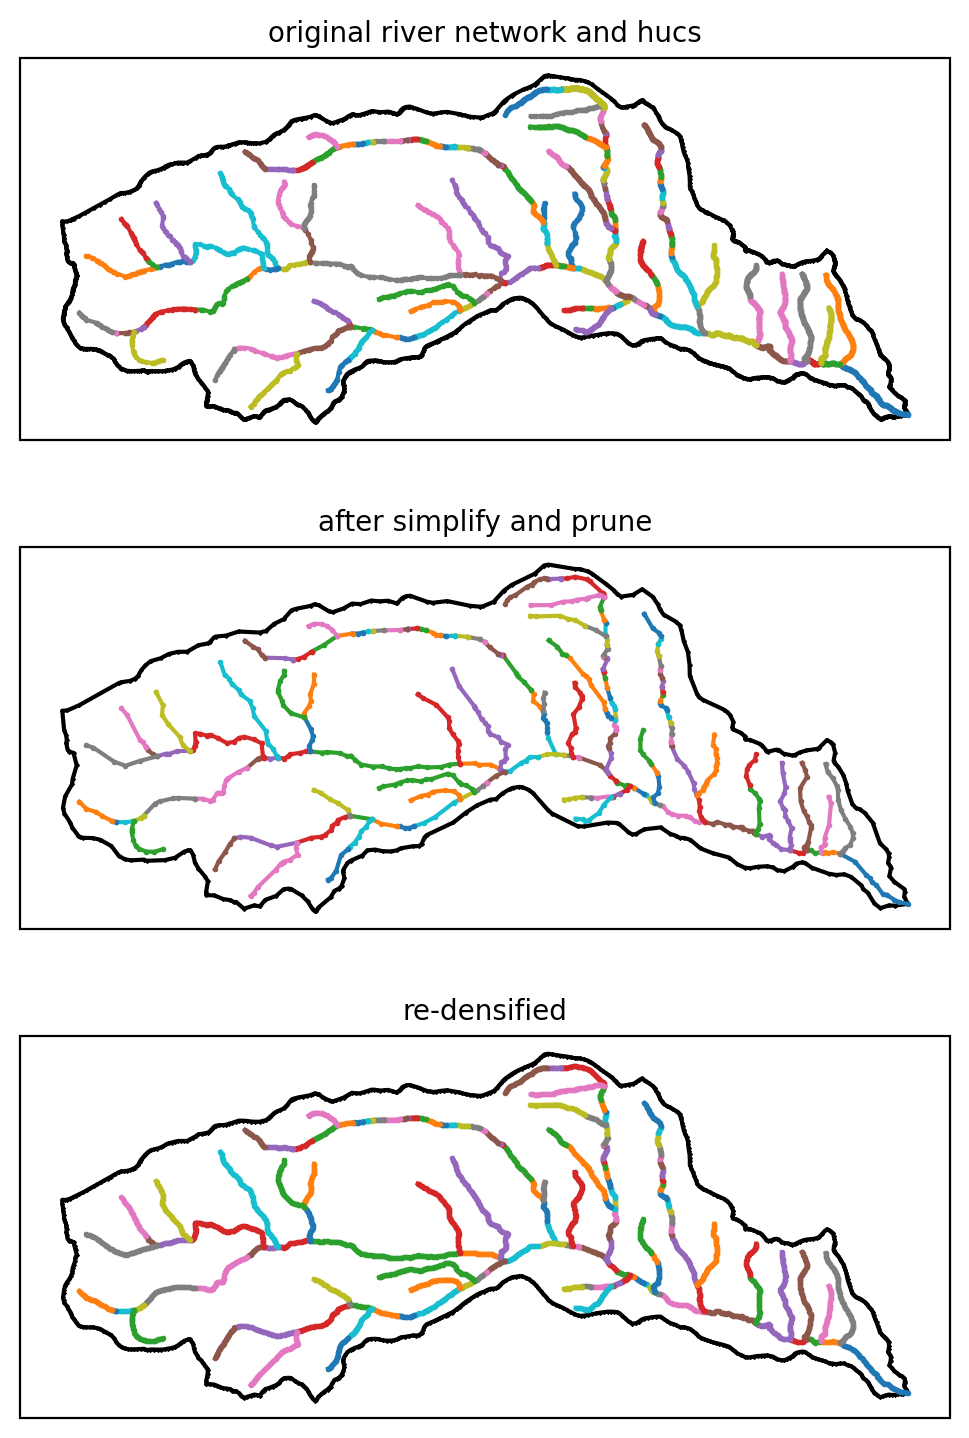

In [19]:
# plotting results
fig, axs = plt.subplots(3,1,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(figsize[0],figsize[0]*1.5))

for huc in list(watershed_orig.polygons()):
    axs[0].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x', markersize=1)
axs[0].set_title('original river network and hucs',fontsize=10)
for huc in list(watershed_simplified.polygons()):
    axs[1].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x', markersize=1)
axs[1].set_title('after simplify and prune',fontsize=10)
for huc in list(watershed.polygons()):
    axs[2].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x', markersize=1)
axs[2].set_title('re-densified',fontsize=10)
axs[2].plot()

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=1)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=1)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[2].plot(x,y,'-o',markersize=1)

plt.show()

### Generate meshes using river network and watershed shape

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the 
distance from the triangle centroid to the nearest stream.  A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

In [20]:
# how many types of Stream Orders are there
stream_orders = set([r.properties["StreamOrder"] for r in rivers[0].preOrder()])
stream_orders

{1, 2, 3, 4}

In [21]:
widths = [5, 5, 10, 10]

In [22]:
riverwidths = dict(zip(stream_orders, widths))
riverwidths

{1: 5, 2: 5, 3: 10, 4: 10}

2024-11-25 22:25:55,687 - root - INFO: 
2024-11-25 22:25:55,688 - root - INFO: Stream-aligned Meshing
2024-11-25 22:25:55,688 - root - INFO: ------------------------------
2024-11-25 22:25:55,689 - root - INFO: Creating stream-aligned mesh...
2024-11-25 22:25:55,689 - root - INFO: River 0
2024-11-25 22:25:55,690 - root - INFO: ... generating initial polygon through dilation (4 m)
2024-11-25 22:25:55,696 - root - INFO:   -- treating collinearity
2024-11-25 22:25:55,719 - root - INFO:   -- river min seg length: 14.366645112158503
2024-11-25 22:25:55,719 - root - INFO:   -- merging points closer than 4.2 m along the river corridor
2024-11-25 22:25:55,779 - root - INFO: ... defining river-mesh topology (quad elements)
2024-11-25 22:25:55,957 - root - INFO: ... setting width of quad elements
2024-11-25 22:25:56,024 - root - INFO: ... enforcing convexity
2024-11-25 22:25:56,045 - root - INFO: Adjusting rivers at the watershed boundaries...
2024-11-25 22:25:56,046 - root - INFO:   adjusting H

total area= 73391940.53918457 m^2
74028893.38327774
74030500.23350021


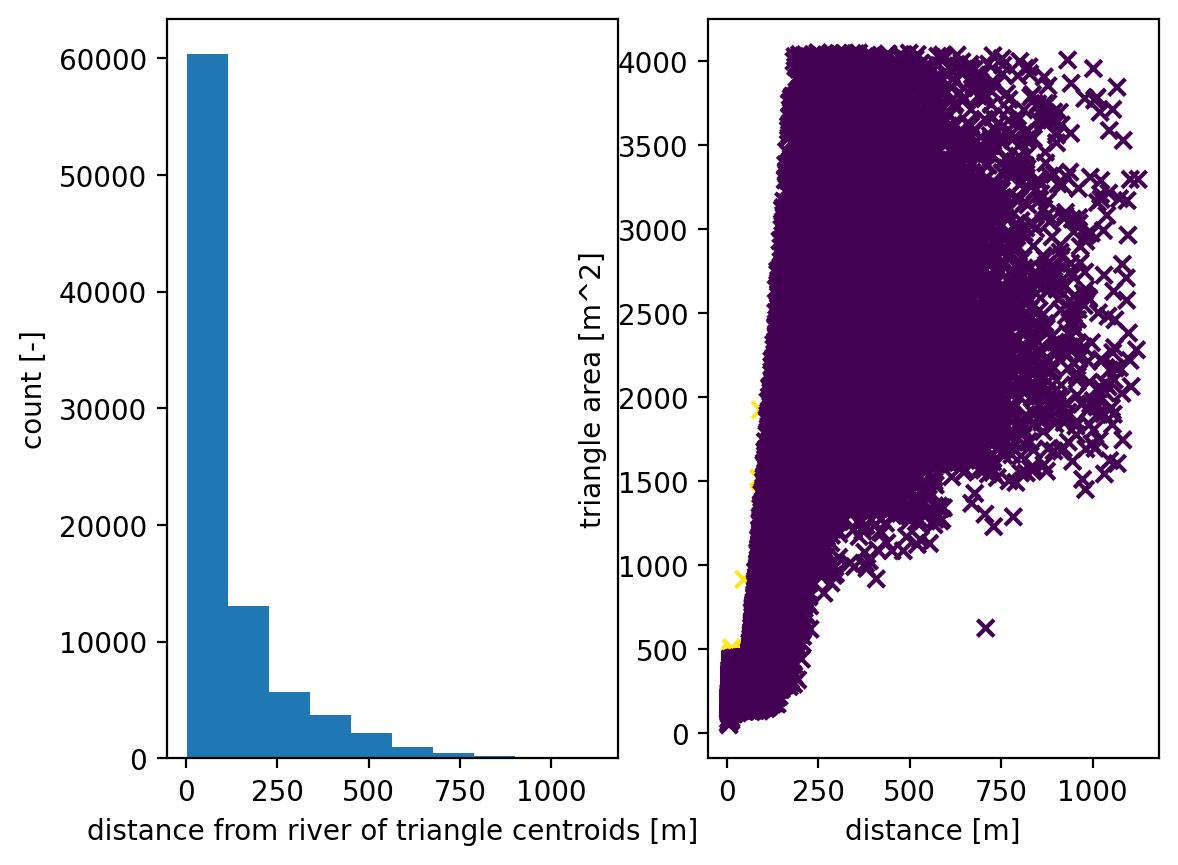

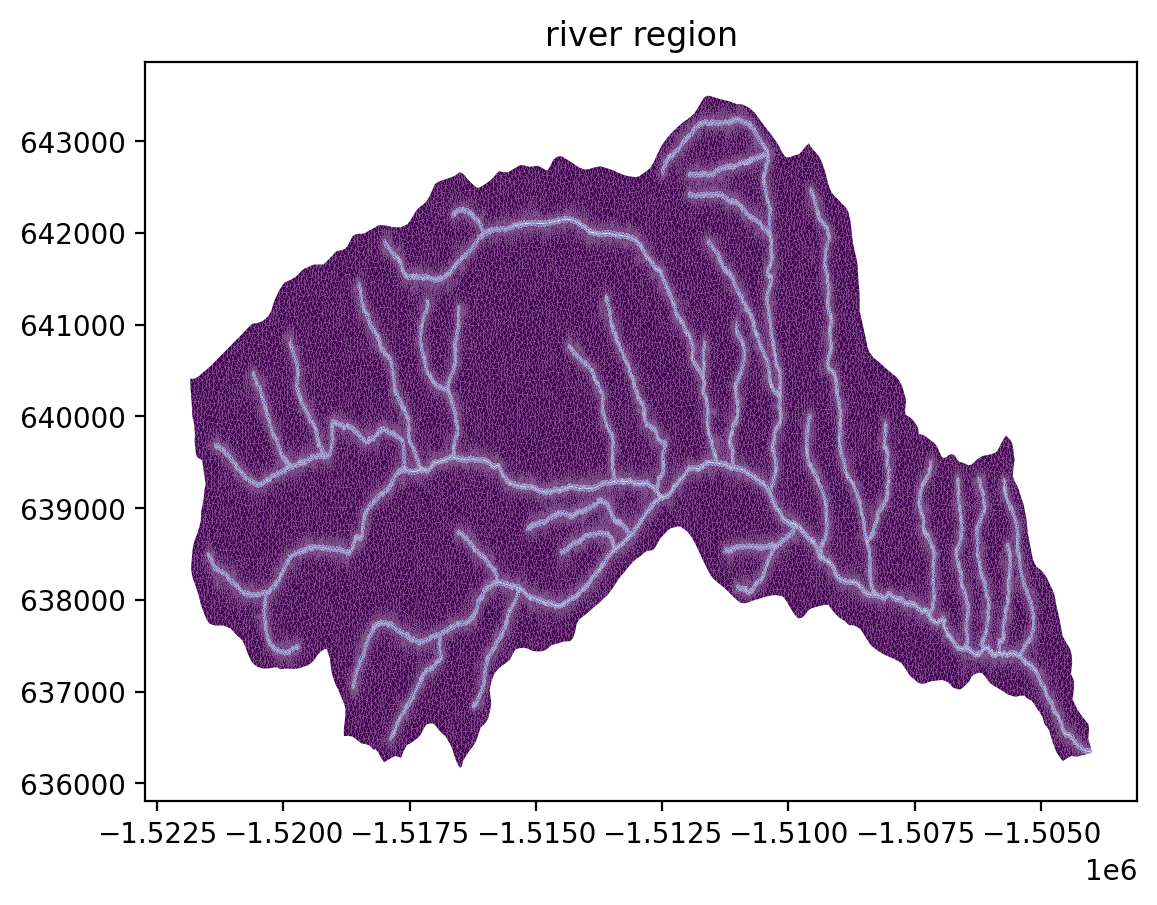

In [23]:
## Triangulation
refine_d0 = meshsize*(factor-1) if factor >= 2 else meshsize
refine_d1 = meshsize*(factor-1)*3 if factor >= 2 else meshsize*3
refine_A0 = (meshsize**2)/2
refine_A1 = (np.round(meshsize*factor))**2/2

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
diagnostics = True


mesh_points2, conn_list, areas, dists, river_idx = watershed_workflow.tessalate_river_aligned(watershed, rivers, 
                                                                                              river_width=riverwidths,
                                                                                              refine_min_angle=min_angle,
                                                                                              refine_distance=[d0,A0,d1,A1],
                                                                                              diagnostics=True,
                                                                                              river_region_dist=meshsize)

print('total area=', np.sum(areas), 'm^2')
print(sum([my_hucs[i].area for i in range(len(my_hucs))]))
print(watershed.exterior().area)

In [24]:
river_idx

array([ True, False, False, ..., False, False, False])

In [25]:
str(len(river_idx[river_idx])/len(river_idx)*100)+'%'

'18.90628597743495%'

In [28]:
mesh_tris = []
for c in conn_list:
    if len(c) == 3:
        mesh_tris.append(c)

for c in mesh_tris:
    if len(c) != 3:
        print(c)

### Map mesh to DEM

Download a DEM from USGS NED and elevate the triangle nodes to the DEM.

In [29]:
# download the needed rasters
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2024-11-25 22:30:16,524 - root - INFO: 
2024-11-25 22:30:16,525 - root - INFO: Loading Raster
2024-11-25 22:30:16,525 - root - INFO: ------------------------------
2024-11-25 22:30:16,526 - root - INFO: Collecting raster
2024-11-25 22:30:16,536 - root - INFO: Collecting DEMs to tile bounds: [-121.07459223710717, 46.68002478794442, -120.80390682603797, 46.782040983650475]
2024-11-25 22:30:16,592 - root - INFO:   Need:
2024-11-25 22:30:16,593 - root - INFO:     /global/cfs/cdirs/m1800/zhi/ww/scripts/data/dem/USGS_NED_13as_n47_w122.tif
2024-11-25 22:30:16,593 - root - INFO:     /global/cfs/cdirs/m1800/zhi/ww/scripts/data/dem/USGS_NED_13as_n47_w121.tif
2024-11-25 22:30:16,613 - root - INFO: source files already exist!
2024-11-25 22:30:17,173 - root - INFO: ... got raster of shape: (1102, 2923)
2024-11-25 22:30:17,175 - root - INFO: ... got raster bounds: (-121.07459223710717, 46.782040983650475, -120.80394408866786, 46.68000394650367)


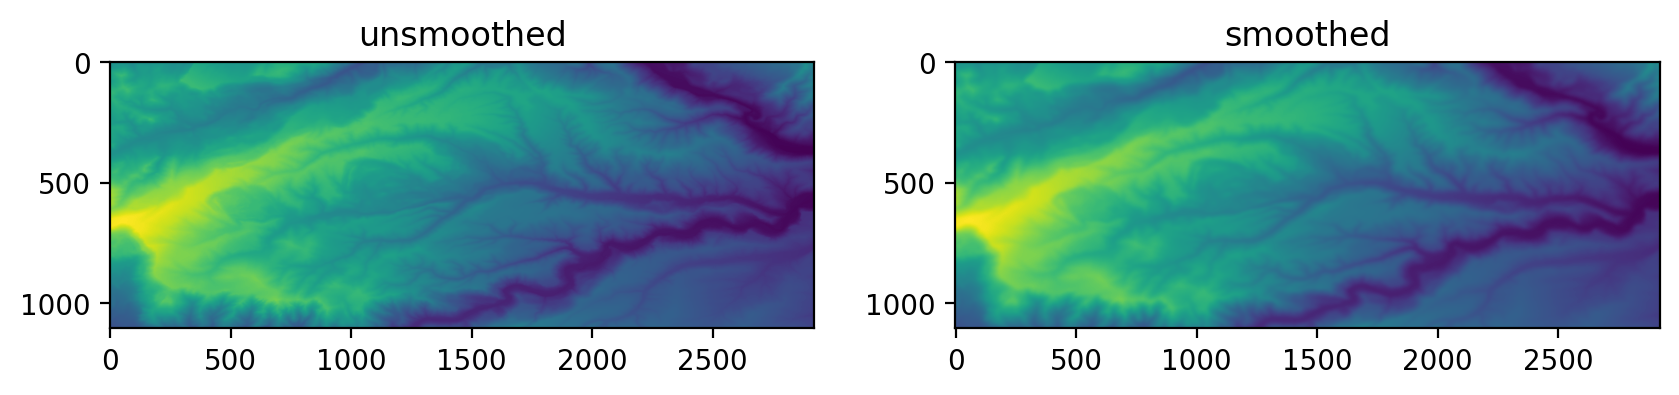

In [30]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
if num_smoothing_sweeps > 0:
    dem_sm = scipy.ndimage.gaussian_filter(dem, num_smoothing_sweeps, mode='nearest')
else:
    dem_sm = dem[:]

if generate_plots:
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(dem)
    axs[0].set_title('unsmoothed')
    axs[1].imshow(dem_sm)
    txt = axs[1].set_title('smoothed')

In [31]:
# elevate the x,y points onto the DEM to get a z coordinate
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem_sm, dem_profile)

In [32]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

In [33]:
# hydrologically condition the mesh, removing pits.

# replace conditioned mesh where there are water bodies!
all_bodies = shapely.geometry.MultiPolygon(waterbodies)

waterbody_mask = np.zeros((len(m2.conn),), 'i')
for i,p in enumerate(m2.centroids):
    if all_bodies.contains(shapely.geometry.Point(p)):
        waterbody_mask[i] = 1
        
print(waterbody_mask.shape)
print(waterbody_mask.sum())
# NOTE: this fills reservoirs as well!  Might have to think about how to allow some pits!
# watershed_workflow.condition.fill_pits_dual(m2, is_waterbody=waterbody_mask)

(90367,)
0


In [34]:
# image the diff of the elevation
# if generate_plots:
#     diff = m2.coords[:,2] - mesh_points3[:,2]
    
#     fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(12,10))

#     mp = watershed_workflow.plot.triangulation(m2.coords, m2.conn, crs, ax=ax, 
#                                  color=diff, edgecolor='white', linewidth=0.2)

1


/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-descr

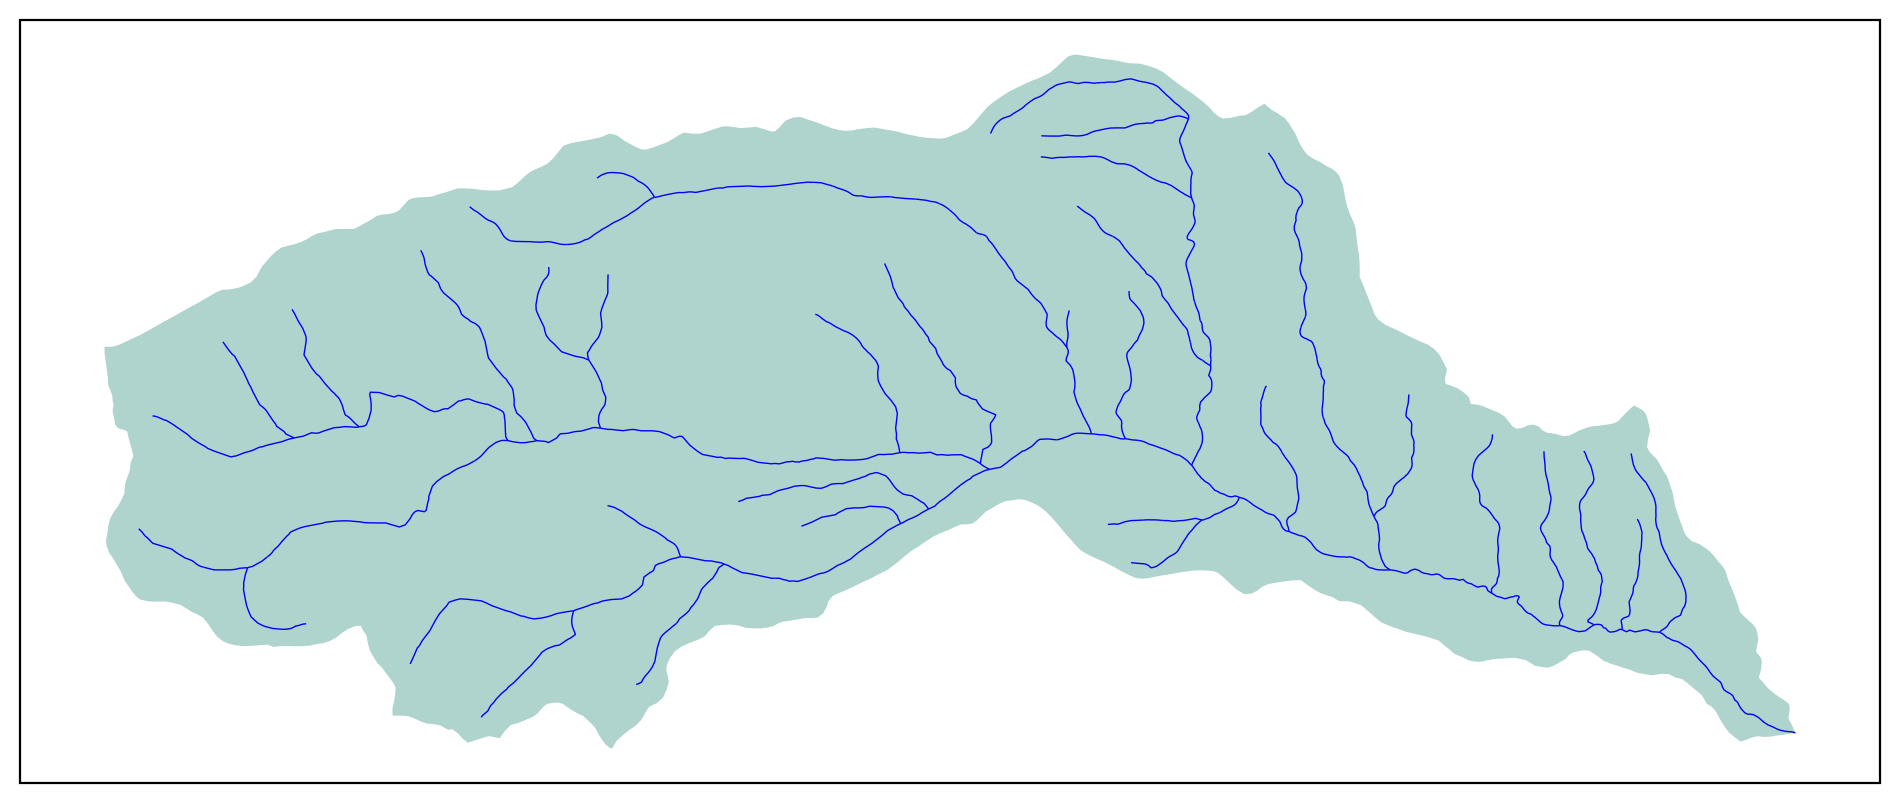

In [35]:
# identify outlets by the elevation map
#watershed_workflow.split_hucs.find_outlets_by_elevation(watershed, crs, dem_sm, dem_profile)

print(len(rivers))
rivers = sorted(rivers, key=len)
watershed_workflow.split_hucs.find_outlets_by_hydroseq(watershed, rivers[-1])

if generate_plots:
    fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(12,10))
    colors = watershed_workflow.colors.enumerated_colors(len(watershed), palette=4)
    watershed_workflow.plot.hucs(watershed, crs, ax=ax, color=colors, linewidth=1, facecolor='color', alpha=0.4)
    watershed_workflow.plot.rivers(rivers, crs, ax=ax, colors='b', linewidth=0.5)

In [36]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.elevate_rivers(rivers, crs, dem, dem_profile)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.condition_river_mesh(m2, river, network_burn_in_depth=5)

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0.25, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f346dfa4580>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346dfa4280>, 'edgecolor': 'w'}
setting face color =  [ 760.28325208  761.13192523 1483.13855678 ...  898.86860929  902.16403622
  905.7308472 ]
kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f346dfa4580>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346dfa4280>, 'edgecolor': 'w'}
setting face color =  [ 760.28325208  761.13192523 1483.13855678 ...  898.86860929  902.16403622
  905.7308472 ]


/tmp/ipykernel_1385182/1826181488.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


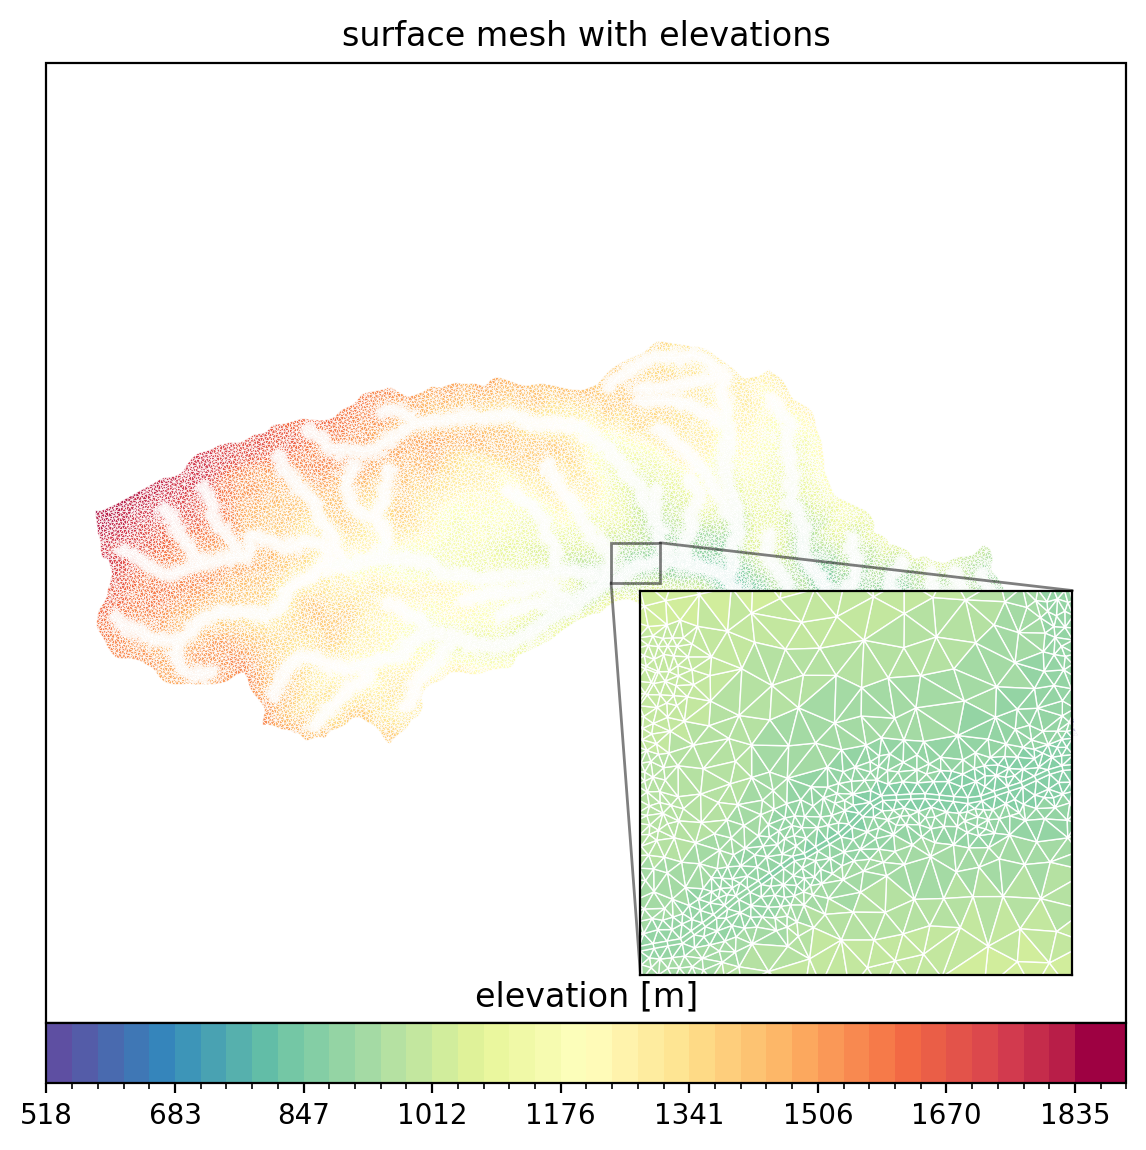

In [37]:
# plotting surface mesh with elevations
if generate_plots:
    start=min(m2.centroids[:,2])
    step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
    stop=max(m2.centroids[:,2])+step
    legend_values=np.arange(start,stop,step)
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='Spectral_r')
    zoom_in_center = (0.55, 0.45)
    zoom_in_box_size = (0.05, 0.1)
    
    
    fig = plt.figure(figsize=figsize)
    ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
    ax2 = ax.inset_axes([0.55,0.05,0.4,0.4])
    cbax = fig.add_axes([0.05,0.05,0.9,0.05])
    
    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                            linewidth=0.25 ,color=m2.centroids[:,2], 
                            cmap=cmap, norm = norm, edgecolor='w', facecolor='color')
    cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
    ax.set_title('surface mesh with elevations')
    ax.set_aspect('equal', 'datalim')
    
    mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2, 
                            linewidth=0.5 ,color=m2.centroids[:,2], 
                            cmap=cmap, norm = norm, edgecolor='w', facecolor='color')
    ax2.set_aspect('equal', 'datalim')
    
    xlim = (min(m2.centroids[:,0])+(max(m2.centroids[:,0]) - min(m2.centroids[:,0]))*(zoom_in_center[0]-zoom_in_box_size[0]/2), 
            min(m2.centroids[:,0])+(max(m2.centroids[:,0]) - min(m2.centroids[:,0]))*(zoom_in_center[0]+zoom_in_box_size[0]/2))
    ylim = (min(m2.centroids[:,1])+(max(m2.centroids[:,1]) - min(m2.centroids[:,1]))*(zoom_in_center[1]-zoom_in_box_size[1]/2), 
            min(m2.centroids[:,1])+(max(m2.centroids[:,1]) - min(m2.centroids[:,1]))*(zoom_in_center[1]+zoom_in_box_size[1]/2))
    
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax.indicate_inset_zoom(ax2, edgecolor='k')
    
    cbar.ax.set_title('elevation [m]')
    plt.tight_layout()
    plt.show()

In [39]:
# find outlet
# watershed_workflow.split_hucs.find_outlets_by_crossings(watershed, rivers[0], debug_plot=False)

In [40]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.add_watershed_regions_and_outlets(m2, watershed, outlet_width=stream_outlet_width, 
                                                          labels=[p.properties[huc_key] for p in watershed.polygons()], exterior_outlet= True)

# add labeled sets for river corridor cells
watershed_workflow.regions.add_river_corridor_regions(m2, rivers)

# add labeled sets for river corridor cells by order
watershed_workflow.regions.add_regions_by_stream_order_rivers(m2, rivers, labels=None)

In [41]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 90367 : "170300020307"
10001 : CELL : 90367 : "170300020307 surface"
10002 : FACE : 691 : "170300020307 boundary"
10003 : FACE : 8 : "170300020307 outlet"
10004 : FACE : 8 : "surface domain outlet"
10005 : CELL : 3507 : "river_corridor 0 surface"
10006 : CELL : 363 : "reaches of StreamOrder 4 in river 0 surface"
10007 : CELL : 779 : "reaches of StreamOrder 3 in river 0 surface"
10008 : CELL : 839 : "reaches of StreamOrder 2 in river 0 surface"
10009 : CELL : 1526 : "reaches of StreamOrder 1 in river 0 surface"


## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [42]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))

2024-11-25 22:35:09,591 - root - INFO: 
2024-11-25 22:35:09,592 - root - INFO: Loading Raster
2024-11-25 22:35:09,592 - root - INFO: ------------------------------
2024-11-25 22:35:09,593 - root - INFO: Collecting raster
2024-11-25 22:35:09,608 - root - INFO:   filename: /global/cfs/cdirs/m1800/zhi/ww/scripts/data/land_cover/NLCD_2019_Land_Cover_L48/NLCD_2019_Land_Cover_L48.img
2024-11-25 22:35:10,125 - root - INFO: ... got raster of shape: (257, 625)
2024-11-25 22:35:10,194 - root - INFO: ... got raster bounds: (-1901115.0, 2891865.0, -1882365.0, 2884155.0)
2024-11-25 22:35:10,408 - root - INFO: Found land cover dtypes: uint8
2024-11-25 22:35:10,414 - root - INFO: Found land cover types: {0, 71, 41, 42, 43, 11, 52, 21, 22, 23, 24, 90, 31, 95}


{42: 49100, 52: 24433, 71: 10407, 21: 4393, 22: 1045, 90: 507, 41: 161, 43: 158, 23: 117, 95: 23, 0: 9, 24: 9, 11: 4, 31: 1}
54.333993603859824 27.037524760144745 11.51637212699326 4.861287859506236


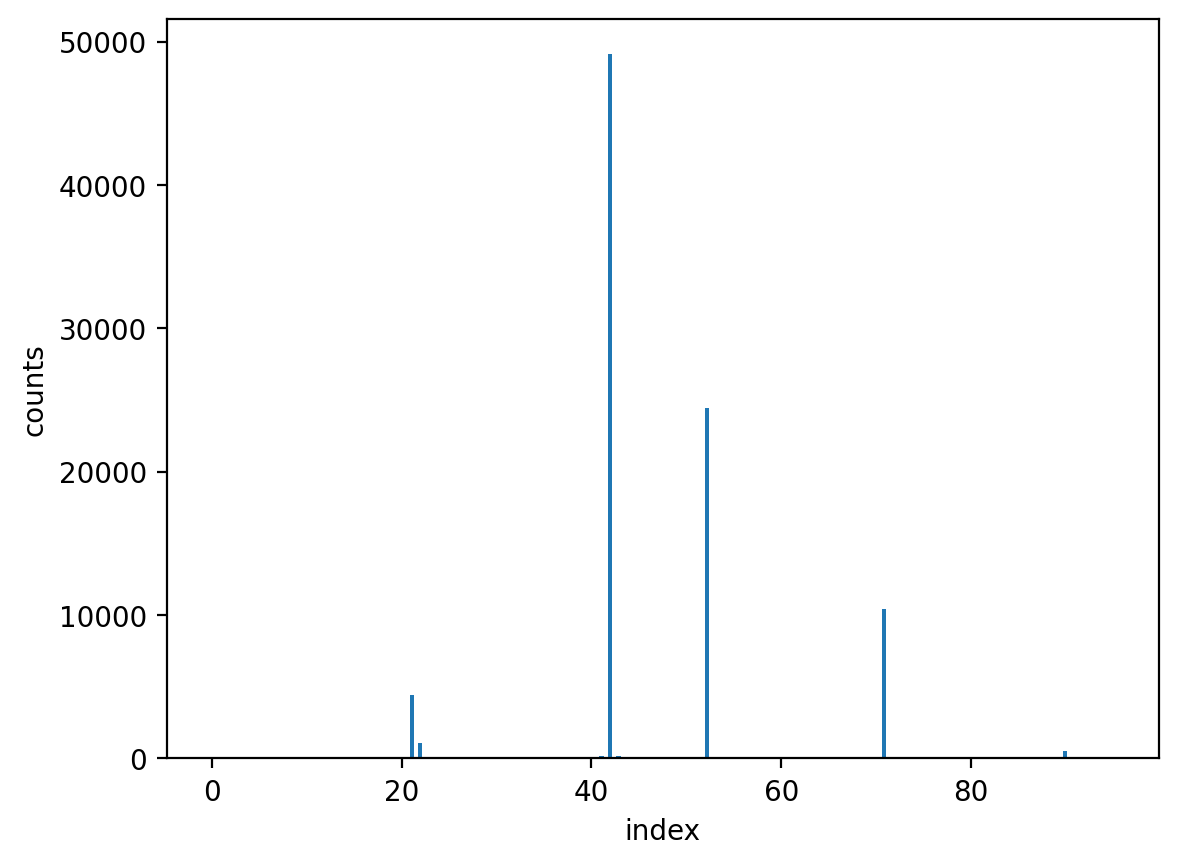

In [43]:
### land cover histogram
u, count = np.unique(lc, return_counts=True)
count_sort_ind = np.argsort(-count)
lc_dict = dict(zip(u[count_sort_ind], count[count_sort_ind]))
print(lc_dict)
aa = count[count_sort_ind]
print(aa[0]/np.sum(aa)*100, aa[1]/np.sum(aa)*100, aa[2]/np.sum(aa)*100, aa[3]/np.sum(aa)*100)
plt.hist(lc, bins='auto')
plt.ylabel('counts')
plt.xlabel('index')
plt.show()

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7f346dc082b0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346dc09660>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [52 52 42 ... 52 52 52]


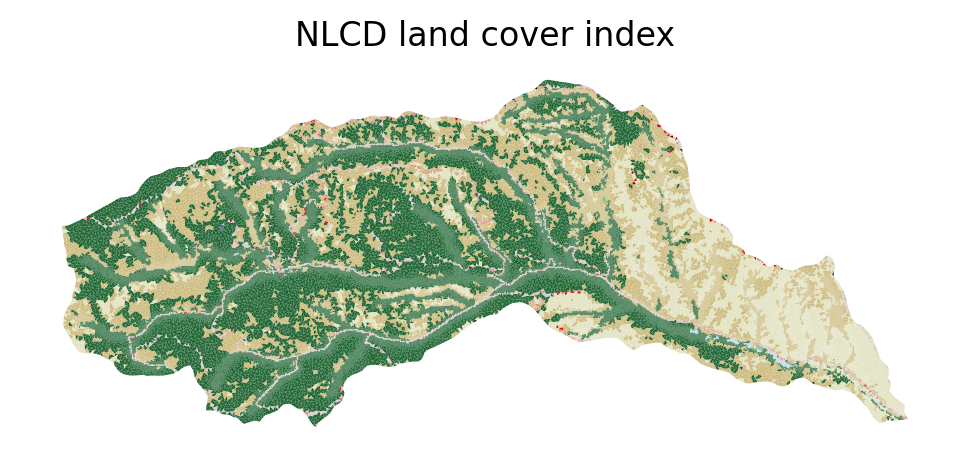

In [45]:
if generate_plots:
    # plot the image
    # -- get the NLCD colormap which uses official NLCD colors and labels
    nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

    fig = plt.figure(figsize=figsize)
    ax = watershed_workflow.plot.get_ax(crs, fig)
    polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

    # nlcd_labels.pop()
    # watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, labels = nlcd_labels) 

    ax.set_title("NLCD land cover index")
    ext = ax.axis('off')
    fig.savefig(f'../images/{name}/{name}_land_cover_raw')

In [46]:
nlcd_indices

[0, 11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 90, 95]

In [47]:
nlcd_labels

['None',
 'Open Water',
 'Developed, Open Space',
 'Developed, Low Intensity',
 'Developed, Medium Intensity',
 'Developed, High Intensity',
 'Barren Land',
 'Deciduous Forest',
 'Evergreen Forest',
 'Mixed Forest',
 'Shrub/Scrub',
 'Grassland/Herbaceous',
 'Woody Wetlands',
 'Emergent Herbaceous Wetlands']

In [48]:
len(nlcd_indices), len(nlcd_labels)

(14, 14)

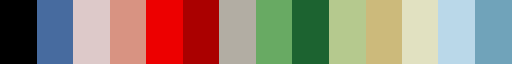

In [49]:
nlcd_cmap

In [50]:
type(nlcd_cmap)

matplotlib.colors.ListedColormap

In [51]:
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
nlcd_labels_dict

{0: 'None',
 11: 'Open Water',
 21: 'Developed, Open Space',
 22: 'Developed, Low Intensity',
 23: 'Developed, Medium Intensity',
 24: 'Developed, High Intensity',
 31: 'Barren Land',
 41: 'Deciduous Forest',
 42: 'Evergreen Forest',
 43: 'Mixed Forest',
 52: 'Shrub/Scrub',
 71: 'Grassland/Herbaceous',
 90: 'Woody Wetlands',
 95: 'Emergent Herbaceous Wetlands'}

In [52]:
# we don't really need all of these.  Keep Evergreen, Deciduous, Shrub, and merge the rest into "Other"
nlcd_color_new = 99 * np.ones_like(lc)

groupings = {
    42 : ['Evergreen Forest',],
    # 41 : ['Deciduous Forest', 'Mixed Forest', 'Woody Wetlands'],
    52 : ['Dwarf Scrub', 'Shrub/Scrub', 'Grassland/Herbaceous', 'Sedge/Herbaceous', 
                     'Pasture/Hay', 'Cultivated Crops'],
    71 : ['Grassland/Herbaceous'],
}

for k,v in groupings.items():
    for label in v:
        index = sources['land cover'].indices[label]
        nlcd_color_new[np.where(lc == index)] = k
    
print(nlcd_color_new)

[52 52 42 ... 52 52 52]


[42 52 71 99]
[49100 24433 10407  6427]
54.333993603859824 27.037524760144745 11.51637212699326


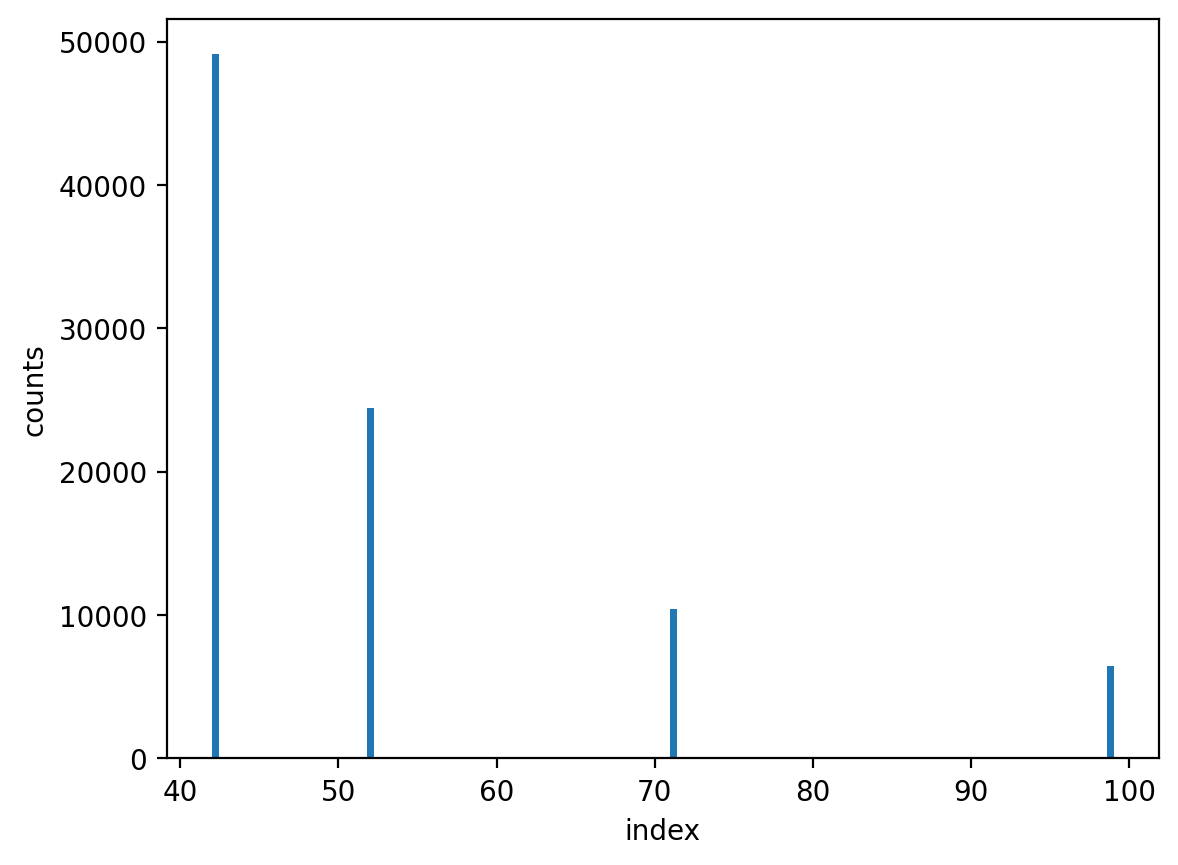

In [53]:
### land cover histogram
u, count = np.unique(nlcd_color_new, return_counts=True)
count_sort_ind = np.argsort(-count)
print(u[count_sort_ind])
print(count[count_sort_ind])
aa = count[count_sort_ind]
print(aa[0]/np.sum(aa)*100, aa[1]/np.sum(aa)*100, aa[2]/np.sum(aa)*100)#, aa[3]/np.sum(aa)*100)
plt.hist(nlcd_color_new, bins='auto')
plt.ylabel('counts')
plt.xlabel('index')
plt.show()

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7f346f26e440>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346f26ee00>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [52 52 42 ... 52 52 52]


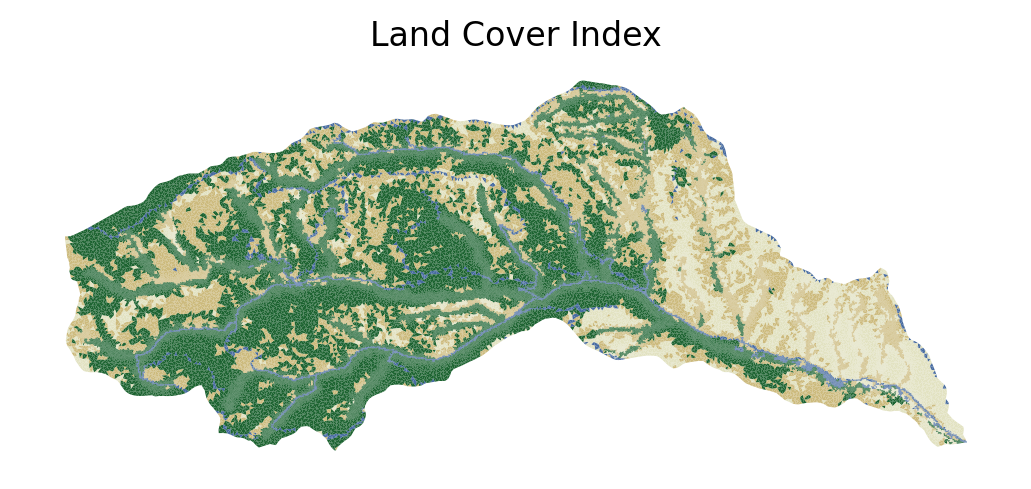

In [54]:
# plot the updated image, adding "other"
nlcd_color_new_other_as_water = np.where(nlcd_color_new == 99, 11, nlcd_color_new)

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
            watershed_workflow.colors.generate_nlcd_colormap(nlcd_color_new_other_as_water)

# make (water, 11) into (other, 99)
nlcd_labels[0] = 'Other'
nlcd_indices[0] = 99

if generate_plots:
    fig, ax = watershed_workflow.plot.get_ax(crs)


    polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new_other_as_water, 
                           cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                           facecolor='color', linewidth=0.5)
    # nlcd_labels.pop()
    # watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(nlcd_color_new_other_as_water)), 
    #                            cmap=nlcd_cmap, labels = nlcd_labels) 

    ax.set_title("Land Cover Index")
    ext = ax.axis('off')
    fig.savefig(f'../images/{name}/{name}_land_cover')



In [55]:
# # add labeled sets to the mesh for NLCD
# nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
# watershed_workflow.mesh.add_nlcd_labeled_sets(m2, nlcd_color_new, nlcd_labels_dict)

In [56]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.add_nlcd_labeled_sets(m2, nlcd_color_new, nlcd_labels_dict)

In [57]:
### land cover histogram
print(nlcd_labels_dict)

{99: 'Other', 42: 'Evergreen Forest', 52: 'Shrub/Scrub', 71: 'Grassland/Herbaceous'}


In [58]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "170300020307"
10001 : CELL : "170300020307 surface"
10002 : FACE : "170300020307 boundary"
10003 : FACE : "170300020307 outlet"
10004 : FACE : "surface domain outlet"
10005 : CELL : "river_corridor 0 surface"
10006 : CELL : "reaches of StreamOrder 4 in river 0 surface"
10007 : CELL : "reaches of StreamOrder 3 in river 0 surface"
10008 : CELL : "reaches of StreamOrder 2 in river 0 surface"
10009 : CELL : "reaches of StreamOrder 1 in river 0 surface"
42 : CELL : "Evergreen Forest"
52 : CELL : "Shrub/Scrub"
71 : CELL : "Grassland/Herbaceous"
99 : CELL : "Other"


## Subsurface properties

The default model uses GLHYMPS to identify geologic formations, and 

In [59]:
# download the NRCS soils data as shapes and project it onto the mesh
#
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], list(watershed.polygons()), crs, 
                                                     crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = list(soil_survey_props['mukey'][:])
soil_survey_props.set_index('mukey', inplace=True)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)

2024-11-25 22:36:29,198 - root - INFO: 
2024-11-25 22:36:29,199 - root - INFO: Loading shapes
2024-11-25 22:36:29,199 - root - INFO: ------------------------------
2024-11-25 22:36:29,241 - root - INFO: Attempting to download source for target '/global/cfs/cdirs/m1800/zhi/ww/scripts/data/soil_structure/SSURGO/SSURGO_-121.0753_46.6804_-120.8133_46.7892.shp'
2024-11-25 22:36:29,348 - root - INFO:   Found 815 shapes.
2024-11-25 22:36:29,350 - root - INFO:   and crs: EPSG:4326
2024-11-25 22:36:29,350 - root - INFO:   Downloaded 815 total shapes
2024-11-25 22:36:29,351 - root - INFO:   Downloaded 89 unique mukeys
2024-11-25 22:36:29,580 - root - INFO: found 89 unique MUKEYs.
2024-11-25 22:36:31,157 - root - INFO: Running Rosetta for van Genutchen parameters
2024-11-25 22:36:31,347 - root - INFO:   ... done
2024-11-25 22:36:31,349 - root - INFO:   requested 85 values
2024-11-25 22:36:31,349 - root - INFO:   got 85 responses
2024-11-25 22:36:31,358 - root - INFO: ... found 89 shapes
2024-11-2

In [60]:
soil_survey_props

residual saturation [-]  Rosetta porosity [-]  \
mukey                                                    
68891                   0.239901              0.472414   
68893                   0.232636              0.449268   
68898                        NaN                   NaN   
68899                   0.197492              0.409810   
68900                   0.197492              0.409810   
...                          ...                   ...   
75691                        NaN                   NaN   
75696                   0.150562              0.493175   
679189                       NaN                   NaN   
1474345                 0.209320              0.418924   
1474348                 0.209320              0.418924   

         van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
mukey                                                       
68891                       0.000073             1.350836   
68893                       0.000064             1.384238   
68898                            NaN                  NaN   
68899                       0.000074             1.438923   
68900                       0.000074             1.438923   
...                              ...                  ...   
75691                            NaN                  NaN   
75696                       0.000125             1.499806   
679189                           NaN                  NaN   
1474345                     0.000061             1.435421   
1474348                     0.000061             1.435421   

         Rosetta permeability [m^2]  thickness [cm]  permeability [m^2]  \
mukey                                                                     
68891                  2.406729e-13       36.000000        3.737193e-13   
68893                  2.079313e-13       64.250000        4.671889e-13   
68898                           NaN      152.000000        3.000000e-11   
68899                  2.824366e-13      114.000000        9.000000e-13   
68900                  2.824366e-13      114.000000        9.000000e-13   
...                             ...             ...                 ...   
75691                           NaN      152.000000                 NaN   
75696                  2.442779e-12      139.210526        1.654091e-12   
679189                          NaN             NaN                 NaN   
1474345                2.332452e-13      152.000000        6.004281e-13   
1474348                2.332452e-13      152.000000        6.004281e-13   

         porosity [-]  bulk density [g/cm^3]  total sand pct [%]  \
mukey                                                              
68891        0.152000               1.270000           28.900000   
68893        0.240691               1.301782           29.597760   
68898             NaN               2.180000                 NaN   
68899        0.235056               1.349663           43.073034   
68900        0.235056               1.349663           43.073034   
...               ...                    ...                 ...   
75691             NaN                    NaN                 NaN   
75696        0.426404               1.003736           70.486499   
679189            NaN                    NaN                 NaN   
1474345      0.449868               1.336974           34.979605   
1474348      0.449868               1.336974           34.979605   

         total silt pct [%]  total clay pct [%] source  
mukey                                                   
68891             34.400000           36.700000   NRCS  
68893             40.061268           30.340972   NRCS  
68898                   NaN                 NaN   NRCS  
68899             39.803371           17.123596   NRCS  
68900             39.803371           17.123596   NRCS  
...                     ...                 ...    ...  
75691                   NaN                 NaN   NRCS  
75696             20.226697            9.286804   NRCS  
679189                  NaN  

In [61]:
print('soil_color: ', soil_color)
print('soil_color.shape: ', soil_color.shape)
print('len(np.unique(soil_ids)): ', len(np.unique(soil_ids)))
print('len(np.unique(soil_color)): ', len(np.unique(soil_color)))
print('np.unique(soil_ids): ', np.unique(soil_ids))
print('np.unique(soil_color): ', np.unique(soil_color))

soil_color:  [68989. 68989. 75633. ... 69045. 69045. 69045.]
soil_color.shape:  (90367,)
len(np.unique(soil_ids)):  89
len(np.unique(soil_color)):  52
np.unique(soil_ids):  [  68891   68893   68898   68899   68900   68901   68914   68921   68922
   68925   68931   68932   68933   68934   68935   68936   68938   68939
   68940   68941   68947   68971   68972   68973   68981   68986   68988
   68989   69000   69028   69029   69030   69031   69032   69033   69034
   69039   69040   69041   69042   69043   69044   69045   69046   69048
   69049   69051   69054   69058   69063   69073   75302   75305   75307
   75308   75312   75356   75375   75378   75380   75384   75387   75404
   75414   75415   75466   75487   75490   75497   75499   75531   75537
   75539   75543   75572   75586   75594   75604   75612   75618   75624
   75626   75633   75637   75691   75696  679189 1474345 1474348]
np.unique(soil_color):  [ 68891.  68893.  68898.  68899.  68900.  68901.  68914.  68921.  68922.
  68925

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f346cdab640>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346cdab910>}
setting face color =  [68989. 68989. 75633. ... 69045. 69045. 69045.]


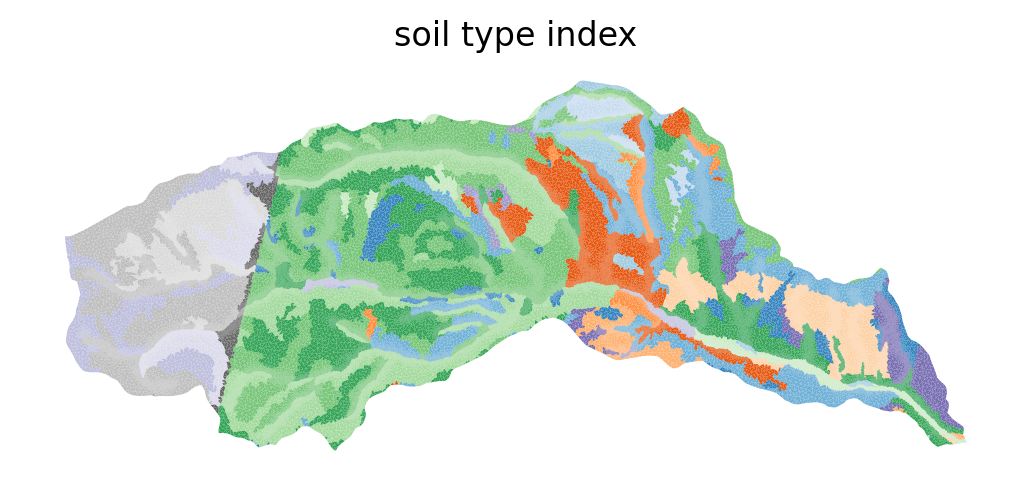

In [62]:
if generate_plots:
    # plot the soil mukey
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=soil_color, 
                            cmap=cmap, norm = norm
                           )

    # watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels=labels) 

    ax.set_title('soil type index')
    ax.axis('off')

In [64]:
# what does soil thickness look like?
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

soil_thickness = soil_thickness / 100
soil_thickness = np.where(np.isnan(soil_thickness), 2.0, soil_thickness)

# if generate_plots:
#     fig, ax = watershed_workflow.plot.get_ax(crs)
#     mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
#                                  color=soil_thickness, edgecolor='none', cmap='jet')
#     ax.set_title('soil thickness [m]')
#     cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
#     ax.axis('off')

print('Median soil thickness [m] = ', np.median(soil_thickness))

Median soil thickness [m] =  1.52


In [67]:
print('# of nan: ', len(iprop[np.isnan(iprop)]))
for i,j in enumerate(iprop):
    if np.isnan(j):
        iprop[i] = np.nanmean(iprop)
print('# of nan: ', len(iprop[np.isnan(iprop)]))

# of nan:  2758
# of nan:  0


In [69]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

assert soil_survey_props_clean['porosity [-]'][:].min() >= min_porosity
assert soil_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
soil_survey_props_clean



native_index  residual saturation [-]  van Genuchten alpha [Pa^-1]  \
0          68891                 0.239901                     0.000073   
1          68893                 0.232636                     0.000064   
2          68899                 0.197492                     0.000074   
3          68900                 0.197492                     0.000074   
4          68901                 0.218532                     0.000093   
..           ...                      ...                          ...   
80         75633                 0.143840                     0.000091   
81         75637                 0.143840                     0.000091   
82         75696                 0.150562                     0.000125   
83       1474345                 0.209320                     0.000061   
84       1474348                 0.209320                     0.000061   

    van Genuchten n [-]  thickness [m]  permeability [m^2]  porosity [-]  \
0              1.350836       0.360000        3.737193e-13      0.152000   
1              1.384238       0.642500        4.671889e-13      0.240691   
2              1.438923       1.140000        9.000000e-13      0.235056   
3              1.438923       1.140000        9.000000e-13      0.235056   
4              1.365972       1.266667        2.896468e-12      0.235056   
..                  ...            ...                 ...           ...   
80             1.511577       1.520000        2.475974e-12      0.364191   
81             1.511577       1.520000        2.475974e-12      0.364191   
82             1.499806       1.392105        1.654091e-12      0.426404   
83             1.435421       1.520000        6.004281e-13      0.449868   
84             1.435421       1.520000        6.004281e-13      0.449868   

   source  
0    NRCS  
1    NRCS  
2    NRCS  
3    NRCS  
4    NRCS  
..    ...  
80   NRCS  
81   NRCS  
82   NRCS  
83   NRCS  
84   NRCS  

[85 rows x 8 columns]

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f346d2dacb0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346d2d9780>}
setting face color =  [1026. 1026. 1080. ... 1041. 1041. 1041.]


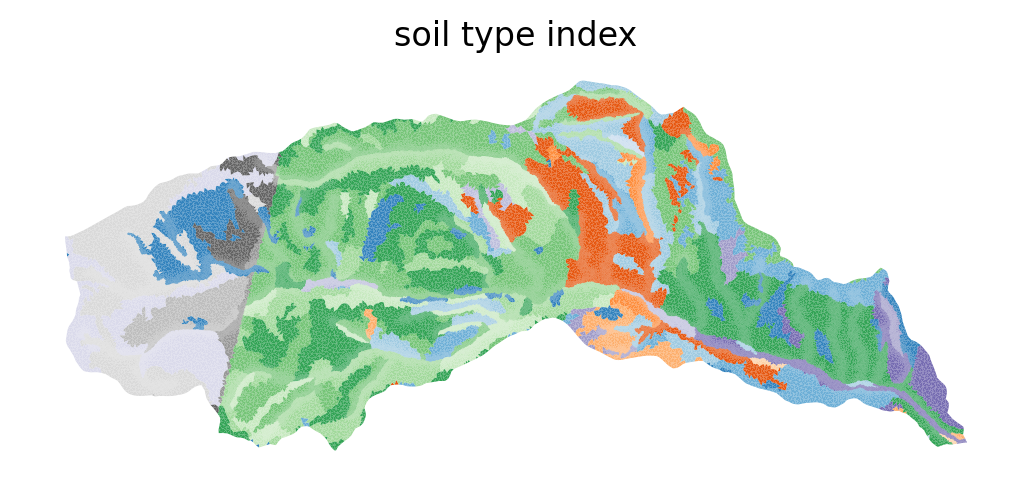

In [70]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukey in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color == mukey)] = 1000+new_id

if generate_plots:
    # image the new soil_color
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

    # watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

    ax.set_title('soil type index')
    ax.axis('off')
    fig.savefig(f'../images/{name}/{name}_soil_indices')

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.  Instead we rely on scaling laws to fill the data.

In [71]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = watershed_workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True,
                                                      min_porosity=min_porosity, 
                                                      max_permeability=max_permeability,
                                                      max_vg_alpha=max_vg_alpha)

# -- log the bounds targeted and found
# logging.info('shape union bounds: {}'.format(
#     shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2024-11-25 22:37:45,630 - root - INFO: target bounds: (-1521842.222472111, 636170.9978430516, -1503991.3075505565, 643495.1460236416)
2024-11-25 22:37:45,631 - root - INFO: 
2024-11-25 22:37:45,632 - root - INFO: Loading shapes
2024-11-25 22:37:45,632 - root - INFO: ------------------------------
2024-11-25 22:37:45,632 - root - INFO: Getting shapes of GLHYMPS on bounds: (-1521842.222472111, 636170.9978430516, -1503991.3075505565, 643495.1460236416)
2024-11-25 22:37:46,064 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
2024-11-25 22:37:53,380 - root - INFO: ... found 14 shapes
2024-11-25 22:37:53,381 - root - INFO: Converting to shapely
2024-11-25 22:37:53,385 - root - INFO:  ... done
2024-11-25 22:37:53,386 - root - INFO: Converting to requested CRS
2024-11-25 22:37:53,397 - root - INFO:  ... done
2024-11-25 22:37:53,398 - root - INFO: Coloring shapes onto raster:
2024-11-25 22:37:53,402 - root - INFO:   of shape: (733, 1787)
2024-11-25 22:37:53,402 - root - INFO:   and 14 ind

In [72]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f346f472140>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346f4720b0>}
setting face color =  [736557. 736557. 736849. ... 736557. 736557. 736557.]


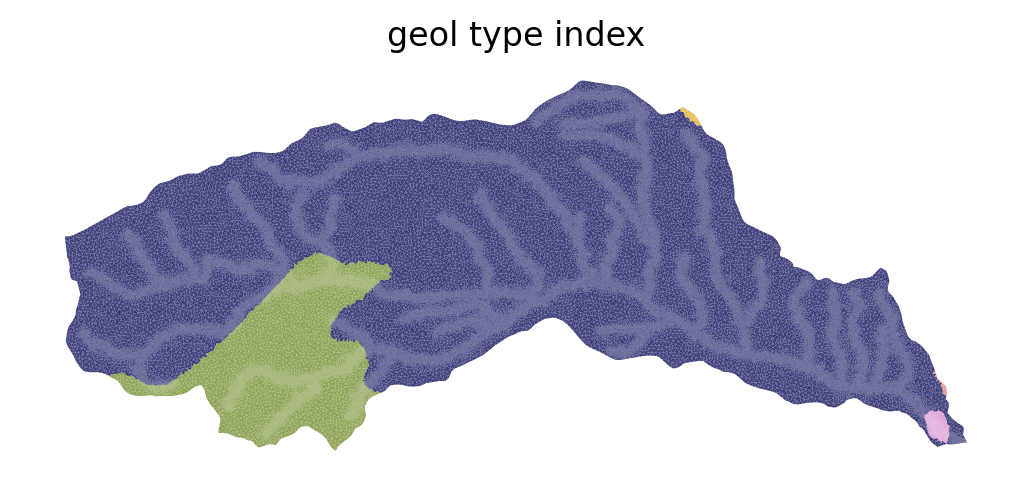

In [73]:
if generate_plots:
    # plot the geologic formation id
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color, 
                        cmap=cmap, norm=norm)

    # watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

    ax.set_title('geol type index')
    ax.axis('off')


In [76]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
assert geo_survey_props_clean['porosity [-]'][:].min() >= min_porosity
assert geo_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
assert geo_survey_props_clean['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

geo_survey_props_clean

/tmp/ipykernel_1385182/270409422.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))


native_index   source  permeability [m^2]  porosity [-]  \
0          (736892, 736936)  GLHYMPS        3.162278e-13          0.09   
1  (736557, 736849, 736951)  GLHYMPS        6.309573e-16          0.19   

   van Genuchten alpha [Pa^-1]  van Genuchten n [-]  residual saturation [-]  
0                     0.000817                  2.0                     0.01  
1                     0.000025                  2.0                     0.01

/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f346f33b790>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f346f33b640>}
setting face color =  [101. 101. 101. ... 101. 101. 101.]


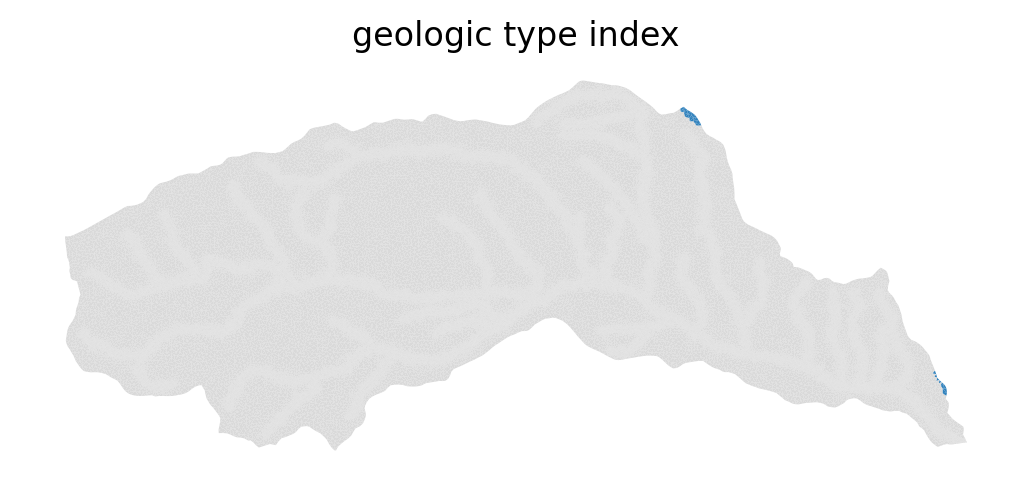

In [77]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
if generate_plots:
    # image the new geo_color
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

    # watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

    ax.set_title('geologic type index')
    ax.axis('off')
    fig.savefig(f'../images/{name}/{name}_geo_indices')

In [78]:
assert(geo_color_new.min() > 0)

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [79]:
# DTB_source = watershed_workflow.source_list.structure_sources['SoilGrids2017']
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], watershed.exterior(), crs, 
                                                       nodata=-99999)#, variable='BDTICM')

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2024-11-25 22:39:16,755 - root - INFO: 
2024-11-25 22:39:16,755 - root - INFO: Loading Raster
2024-11-25 22:39:16,756 - root - INFO: ------------------------------
2024-11-25 22:39:16,756 - root - INFO: Collecting raster
2024-11-25 22:39:16,969 - root - INFO: bounds in my_crs: (-121.06459223710716, 46.69002478794442, -120.81390682603798, 46.77204098365048)
2024-11-25 22:39:17,222 - root - INFO: ... got raster of shape: (40, 121)
2024-11-25 22:39:17,223 - root - INFO: ... got raster bounds: (-121.06459276297448, 46.772089828983894, -120.81250946997437, 46.68875650898386)


/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f346f33b790>}
setting face color =  [19.81038687 18.7362071  16.91166353 ... 19.21481657 19.41801834
 19.33857597]


/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


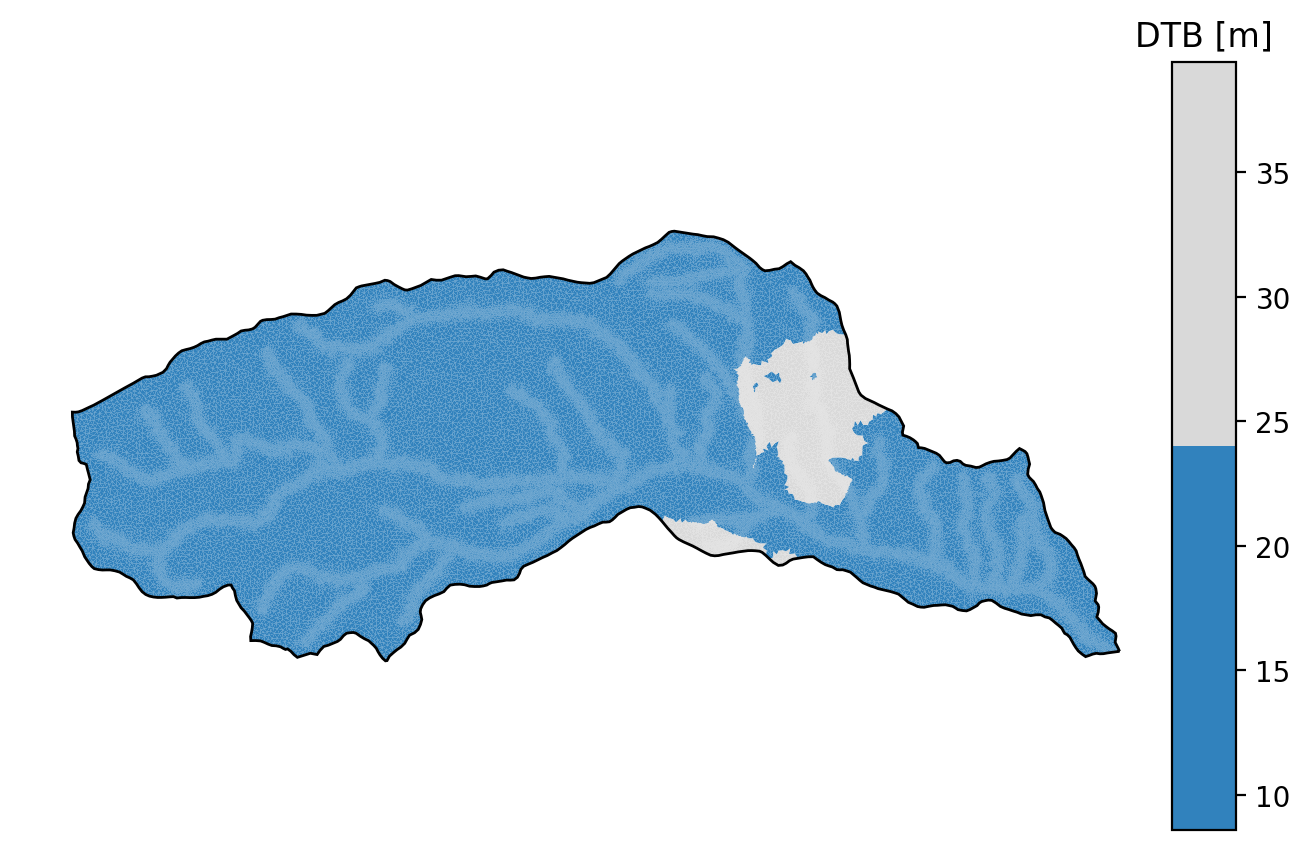

In [80]:
if generate_plots:
    # plot the resulting surface mesh
    fig, ax = watershed_workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
    cbax = fig.add_axes([.95,0.1,0.05,0.8])

    # mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, color=DTB, cmap='plasma_r', edgecolor='none', linewidth=0.1)
    # indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(DTB, cmap='plasma_r')
    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, linewidth=0, color=DTB, cmap=cmap, facecolor='color')
    cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
    watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

    ax.set_aspect('equal', 'datalim')
    ax.axis('off')

    cbar.ax.set_title('DTB [m]')
    fig.savefig(f'../images/{name}/{name}_dtb')

## A combined, complete product?

As a default, we would like a material-driven (e.g. not fields for porosity, perm, etc, but soil classes, each with a common porosity/permeability/vG curve) default that is valid everywhere.  That makes it clear that we must rely on GLHYMPS as the only material-based product that is valid everywhere.  Other products may be layered on top of this, replacing GLHYMPS values, but the underlying layer should be based on GLHYMPS.  To fill in the van Genuchten properties, we relate alpha to permeability and choose a single common n and s_r.

Where available, we then choose to use SSURGO as a layer on top of GLHYMPS.  So start by using all GLHYMPS values, then override ones where SSURGO is valid with those values.  This will be the second model, and has then three layers -- a bedrock layer, a soil layer from 0 to 2m, and a geologic layer, using GLHYMPS values.  SoilGrids depth-to-bedrock will be used to provide the transition between bedrock and (where > 2m) the GLHYMPS "geologic" layer or (where < 2m) the SSURGO "soil" layer.  Where SSURGO has no values, the underlying GLHYMPS values will be used even in the top 2m.


Note, all integer IDs in mesh files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [81]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])

# save the properties to disk for use in generating input file
outputs['subsurface_properties_filename'] = f'../data-processed/{name}/{name}_subsurface_properties.csv'
subsurface_props.to_csv(outputs['subsurface_properties_filename'])
subsurface_props


native_index   source  permeability [m^2]  porosity [-]  \
ats_id                                                                        
100             (736892, 736936)  GLHYMPS        3.162278e-13      0.090000   
101     (736557, 736849, 736951)  GLHYMPS        6.309573e-16      0.190000   
1000                       68891     NRCS        3.737193e-13      0.152000   
1001                       68893     NRCS        4.671889e-13      0.240691   
1002                       68899     NRCS        9.000000e-13      0.235056   
...                          ...      ...                 ...           ...   
1081                       75637     NRCS        2.475974e-12      0.364191   
1082                       75696     NRCS        1.654091e-12      0.426404   
1083                     1474345     NRCS        6.004281e-13      0.449868   
1084                     1474348     NRCS        6.004281e-13      0.449868   
999                          NaN      n/a        1.000000e-16      0.050000   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
ats_id                                                     
100                        0.000817             2.000000   
101                        0.000025             2.000000   
1000                       0.000073             1.350836   
1001                       0.000064             1.384238   
1002                       0.000074             1.438923   
...                             ...                  ...   
1081                       0.000091             1.511577   
1082                       0.000125             1.499806   
1083                       0.000061             1.435421   
1084                       0.000061             1.435421   
999                        0.000019             3.000000   

        residual saturation [-]  thickness [m]  
ats_id                                          
100                    0.010000            NaN  
101                    0.010000            NaN  
1000                   0.239901       0.360000  
1001                   0.232636       0.642500  
1002                   0.197492       1.140000  
...                         ...            ...  
1081                   0.143840       1.520000  
1082                   0.150562       1.392105  
1083                   0.209320       1.520000  
1084                   0.209320       1.520000  
999                    0.010000            NaN  

[88 rows x 8 columns]

In [82]:
# # make a giant plot of all the WRMs
# import plot_wrm # $ATS_SRC_DIR/tools/utils
# fig = plt.figure()
# ax = fig.add_subplot(111)

# cm_gl = watershed_workflow.colors.cm_mapper(100, 103, 'winter')
# cm_ss = watershed_workflow.colors.cm_mapper(1000,1017, 'autumn')

# for i in subsurface_props.index:
#     if i < 999:
#         cl = cm_gl(i)
#     else:
#         cl = cm_ss(i)
#     alpha = subsurface_props.loc[i]['van Genuchten alpha [Pa^-1]']
#     n = subsurface_props.loc[i]['van Genuchten n [-]']
#     sr = subsurface_props.loc[i]['residual saturation [-]']
#     vg = plot_wrm.VanGenuchten(alpha, n, sr)
#     plot_wrm.plot(vg, ax, cl)
    
# # include wilting point limiters
# wp1 = plot_wrm.WiltingPointLimiter(7400, 275000)
# wp2 = plot_wrm.WiltingPointLimiter(6600, 255000)
# wp3 = plot_wrm.WiltingPointLimiter(3500, 224000)
# for wp in [wp1, wp2, wp3]:
#     plot_wrm.plot(wp, ax, 'k')

    
# plt.show()

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [83]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
dtb_max = np.nanmax(DTB)
DTB = np.where(np.isnan(DTB), dtb_max, DTB)

total_thickness = np.ceil(DTB.max())
print(f'total thickness: {total_thickness} m')

# total_thickness = 41.0

total thickness: 40.0 m


In [84]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 8)
print(dzs)
print(sum(dzs))

[0.10861599 0.20380135 0.31541618 0.40630691 0.46585948 0.50000009]
2.0


In [85]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [86]:
# 41m total thickness, minus 2m soil thickness, leaves us with 39 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimize_dzs(1, 10, total_thickness-2, 8)
print(dzs2)
print(sum(dzs2))

# how about...
# dzs_geo = [1.0, 3.0, 7.0,] + 3*[12.0,]
# print(dzs_geo)
# print(sum(dzs_geo))

dzs_geo = dzs2.astype(int)
print(dzs_geo)
print(sum(dzs_geo))

[ 1.          2.14800309  4.85313262  9.99899564  9.99986864 10.        ]
38.0
[ 1  2  4  9  9 10]
35


In [87]:
if sum(dzs_geo) != total_thickness - 2:
    dzs_geo[-1] += total_thickness - 2 - sum(dzs_geo)
print(dzs_geo)
print(sum(dzs_geo))

[ 1  2  4  9  9 13]
38


In [88]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        # use glhymps params
        br_or_geo = np.where(depth < DTB, geo_color_new, 999)
        soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    else:
        # use ssurgo down to DTB if it exists
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        soil_or_br_or_geo = np.where(depth < DTB, soil_or_geo, 999)
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        geo_or_br = np.where(depth < DTB, geo_color_new, 999)
    else:
        # only soil, no geo
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        geo_or_br = np.where(depth < DTB, soil_or_geo, 999)
        
    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
len(subsurface_props_used)


2024-11-25 22:39:49,344 - root - INFO: Cell summary:
2024-11-25 22:39:49,345 - root - INFO: ------------------------------------------------------------
2024-11-25 22:39:49,345 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2024-11-25 22:39:49,345 - root - INFO: ------------------------------------------------------------
2024-11-25 22:39:49,345 - root - INFO:  00 	| 00 	| 1026 	|   0.050000 	|   0.000000
2024-11-25 22:39:49,346 - root - INFO:  01 	| 01 	| 1026 	|   0.050000 	|   0.050000
2024-11-25 22:39:49,346 - root - INFO:  02 	| 02 	| 1026 	|   0.050000 	|   0.100000
2024-11-25 22:39:49,346 - root - INFO:  03 	| 03 	| 1026 	|   0.120000 	|   0.150000
2024-11-25 22:39:49,346 - root - INFO:  04 	| 04 	| 1026 	|   0.230000 	|   0.270000
2024-11-25 22:39:49,347 - root - INFO:  05 	| 05 	| 1026 	|   0.500000 	|   0.500000
2024-11-25 22:39:49,347 - root - INFO:  06 	| 06 	|  101 	|   0.500000 	|   1.000000
2024-11-25 22:39:49,347 - root - INFO:  07 	| 07 	|  101 	|   0.500000 	|   1.5

52

In [89]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [90]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    


2D labeled sets
---------------
10000 : CELL : 90367 : "170300020307"
10001 : CELL : 90367 : "170300020307 surface"
10002 : FACE : 691 : "170300020307 boundary"
10003 : FACE : 8 : "170300020307 outlet"
10004 : FACE : 8 : "surface domain outlet"
10005 : CELL : 3507 : "river_corridor 0 surface"
10006 : CELL : 363 : "reaches of StreamOrder 4 in river 0 surface"
10007 : CELL : 779 : "reaches of StreamOrder 3 in river 0 surface"
10008 : CELL : 839 : "reaches of StreamOrder 2 in river 0 surface"
10009 : CELL : 1526 : "reaches of StreamOrder 1 in river 0 surface"
42 : CELL : 49100 : "Evergreen Forest"
52 : CELL : 24433 : "Shrub/Scrub"
71 : CELL : 10407 : "Grassland/Herbaceous"
99 : CELL : 6427 : "Other"

Extruded 3D labeled sets
------------------------
10000 : CELL : 1265138 : "170300020307"

Extruded 3D side sets
---------------------
1 : FACE : 90367 : "bottom"
2 : FACE : 90367 : "surface"
3 : FACE : 9674 : "external_sides"
10001 : FACE : 90367 : "170300020307 surface"
10002 : FACE : 9674 

In [91]:
# save to disk
outputs['mesh_filename'] = f'../data-processed/{name}/{name}_{meshsize}-{int(np.round(meshsize*factor))}.exo'
try:
    os.remove(outputs['mesh_filename'])
    os.remove(outputs['mesh_filename'].replace('.exo','.vtk'))
except FileNotFoundError:
    pass
m3.write_exodus(outputs['mesh_filename'])
# m3.write_vtk(outputs['mesh_filename'].replace('.exo','.vtk'))


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ../data-processed/OakMixed/OakMixed_30-90.exo


2024-11-25 22:40:40,797 - root - INFO: adding side set: 1
2024-11-25 22:40:41,190 - root - INFO: adding side set: 2
2024-11-25 22:40:41,518 - root - INFO: adding side set: 3
2024-11-25 22:40:41,745 - root - INFO: adding side set: 10001
2024-11-25 22:40:42,147 - root - INFO: adding side set: 10002
2024-11-25 22:40:42,382 - root - INFO: adding side set: 10003
2024-11-25 22:40:42,603 - root - INFO: adding side set: 10004
2024-11-25 22:40:42,822 - root - INFO: adding side set: 10005
2024-11-25 22:40:43,046 - root - INFO: adding side set: 10006
2024-11-25 22:40:43,272 - root - INFO: adding side set: 10007
2024-11-25 22:40:43,492 - root - INFO: adding side set: 10008
2024-11-25 22:40:43,712 - root - INFO: adding side set: 10009
2024-11-25 22:40:43,934 - root - INFO: adding side set: 42
2024-11-25 22:40:44,216 - root - INFO: adding side set: 52
2024-11-25 22:40:44,472 - root - INFO: adding side set: 71
2024-11-25 22:40:44,707 - root - INFO: adding side set: 99
2024-11-25 22:40:44,938 - root -

Closing exodus file: ../data-processed/OakMixed/OakMixed_30-90.exo



Exodus Library Warning/Error: [ex_put_set] in file '../data-processed/OakMixed/OakMixed_30-90.exo'


## Collect the DayMet raster covering this area

Note that here we need two files -- the actual data and the typical year data.

The first cell downloads the raw data and generates the actual data file used by ATS, the second cell averages days, smooths the data, and writes a typical year.

In [96]:
# outputs['daymet_filename'] = f'../data-processed/{name}/{name}_DayMet_1980_2022.h5'

# if generate_daymet:
#     start = "1-1980"
#     end = "365-2022"
#     bounds = watershed.exterior().bounds

#     dat, x, y = watershed_workflow.daymet.collectDaymet(bounds, crs, start, end)
#     ats = watershed_workflow.daymet.daymetToATS(dat)
#     attrs = watershed_workflow.daymet.getAttrs(bounds, start, end)
#     watershed_workflow.daymet.writeHDF5(ats, x, y, attrs, outputs['daymet_filename'])

In [97]:
outputs['daymet_filename'] = f'../data-processed/{name}/{name}_DayMet_1980_2023.h5'

if generate_daymet:
    startdate = f"{start_year}-1-1"
    enddate = f"{end_year}-12-31"
    bounds = watershed.exterior().bounds
    
    source = watershed_workflow.sources.manager_daymet.FileManagerDaymet()
    data = source.get_data(bounds, crs, startdate, enddate)

    assert(len(data.collections) == 1)
    met_data = data.collections[0]
    met_data_ats = watershed_workflow.daymet.daymet_to_daily_averages(met_data)
    attrs = watershed_workflow.daymet.getAttributes(bounds, startdate, enddate)
    watershed_workflow.io.write_dataset_to_hdf5(outputs['daymet_filename'], met_data_ats.collections[0], attrs)

2024-11-25 22:41:47,908 - root - INFO: Collecting DayMet file to tile bounds: [-121.0852, 46.6705, -120.8034, 46.7991]
2024-11-25 22:41:47,950 - root - INFO:   Downloading: http://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/2129/daymet_v4_daily_na_tmin_1980.nc
2024-11-25 22:41:47,950 - root - INFO:       to file: /global/cfs/cdirs/m1800/zhi/ww/scripts/data/meteorology/daymet/daymet_tmin_1980_46.7991x-121.0852_46.6705x-120.8034.nc
2024-11-25 22:42:10,830 - root - INFO: Collecting DayMet file to tile bounds: [-121.0852, 46.6705, -120.8034, 46.7991]
2024-11-25 22:42:10,831 - root - INFO:   Downloading: http://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/2129/daymet_v4_daily_na_tmin_1981.nc
2024-11-25 22:42:10,831 - root - INFO:       to file: /global/cfs/cdirs/m1800/zhi/ww/scripts/data/meteorology/daymet/daymet_tmin_1981_46.7991x-121.0852_46.6705x-120.8034.nc
2024-11-25 22:42:34,390 - root - INFO: Collecting DayMet file to tile bounds: [-121.0852, 46.6705, -120.8034, 46.7991]
202

In [98]:
# outputs['daymet_spinup_filename'] = f'../data-processed/{name}/{name}_DayMet_typical_1980_2022.h5'

# if generate_daymet:
#     ats_typ = watershed_workflow.daymet.daymetToATS(dat, smooth=True, smooth_filter=True, nyears=43)
#     watershed_workflow.daymet.writeHDF5(ats_typ, x, y, attrs, outputs['daymet_spinup_filename'])

In [99]:
outputs['daymet_spinup_filename'] = f'../data-processed/{name}/{name}_DayMet_typical_1980_2023.h5'

if generate_daymet:
    data_typ = source.get_data(bounds, crs, startdate, enddate)
    met_data_typ = data_typ.collections[0]
    
    logging.info("averaging daymet by taking the average for each day across the actual years.")
    window, poly_order = 61, 2
    for key in data.collections[0]:
        logging.info(f"smoothing {key} using savgol filter, window = {window} d, poly order = {poly_order}")
        met_data_typ.data[key] = watershed_workflow.utils.compute_average_year(met_data_typ.data[key], output_nyears=end_year-start_year+1, filter=True)    
    
    met_data_typ_ats = watershed_workflow.daymet.daymet_to_daily_averages(met_data_typ)
    watershed_workflow.io.write_dataset_to_hdf5(outputs['daymet_spinup_filename'], met_data_typ_ats.collections[0], attrs)

2024-11-25 22:42:44,212 - root - INFO: Collecting DayMet file to tile bounds: [-121.0852, 46.6705, -120.8034, 46.7991]
2024-11-25 22:42:44,213 - root - INFO:   Using existing: /global/cfs/cdirs/m1800/zhi/ww/scripts/data/meteorology/daymet/daymet_tmin_1980_46.7991x-121.0852_46.6705x-120.8034.nc
2024-11-25 22:42:44,213 - root - INFO: Collecting DayMet file to tile bounds: [-121.0852, 46.6705, -120.8034, 46.7991]
2024-11-25 22:42:44,214 - root - INFO:   Using existing: /global/cfs/cdirs/m1800/zhi/ww/scripts/data/meteorology/daymet/daymet_tmin_1981_46.7991x-121.0852_46.6705x-120.8034.nc
2024-11-25 22:42:44,214 - root - INFO: Collecting DayMet file to tile bounds: [-121.0852, 46.6705, -120.8034, 46.7991]
2024-11-25 22:42:44,215 - root - INFO:   Downloading: http://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/2129/daymet_v4_daily_na_tmin_1982.nc
2024-11-25 22:42:44,215 - root - INFO:       to file: /global/cfs/cdirs/m1800/zhi/ww/scripts/data/meteorology/daymet/daymet_tmin_1982_46.7991x-1

## Generate files for Leaf Area Index

In addition to meteorological forcing data, we need land cover leaf area index data.  Typically this can be smoother than the DayMet, and our default source for this, MODIS, is not currently automated.  Therefore this assumes you have already acquired the raw MODIS data (note -- get Pin to add his scripts for this!)

MODIS is available from 2002 to present -- we generate a typical year and can use that for all years, though probably we should do something smarter if possible.

In [120]:
def plot(df, form, axs):
    cm = watershed_workflow.colors.enumerated_colors(3)
    i = 0
    for k in df.keys():
        if not k.startswith('time'):
            axs[i].plot(df['time [d]'], df[k], form, color=cm[i])
            axs[i].set_title(k)
            i += 1

In [121]:
# load the raw MODIS data and covert it to pandas
ats_raw_modis_filename = f'../data-processed/{name}/{name}_MODIS_LAI_07042002_10152024.h5'

if generate_modis:
    d = h5py.File(ats_raw_modis_filename,'r')
    df = pandas.DataFrame()
    for k in d.keys():
        df[k] = d[k][:]
    df['time [d]'] = df['time [s]']/86400
df if generate_modis else generate_modis

NLCD Evergreen Forest LAI [-]  NLCD Grassland Herbaceous LAI [-]  \
0                          0.993478                           0.525134   
1                          1.485507                           0.492513   
2                          1.536957                           0.587701   
3                          1.377536                           0.489305   
4                          1.467391                           0.467380   
...                             ...                                ...   
2015                       0.905797                           0.315508   
2016                       0.880435                           0.302139   
2017                       0.876087                           0.282353   
2018                       0.797101                           0.295722   
2019                       0.455072                           0.262032   

      NLCD Shrub Scrub LAI [-]     time [s]  time [d]  
0                     1.022053          0.0       0.0  
1                     1.181492     259200.0       3.0  
2                     1.163069     604800.0       7.0  
3                     1.133347     950400.0      11.0  
4                     1.074983    1296000.0      15.0  
...                        ...          ...       ...  
2015                  0.750505  694137600.0    8034.0  
2016                  0.719278  694483200.0    8038.0  
2017                  0.704225  694828800.0    8042.0  
2018                  0.664509  695174400.0    8046.0  
2019                  0.453325  695520000.0    8050.0  

[2020 rows x 5 columns]

In [122]:
if generate_modis:
    # interpolate this time series into a daily time series
    # ts = np.arange(8214, 14600, 1)
    ts = np.arange(df['time [d]'].values[-1]+1)
    df_interp = pandas.DataFrame()
    df_interp['time [d]'] = ts

    for k in df.keys():
        if k != 'time [s]':
            f = scipy.interpolate.interp1d(df['time [d]'][:], df[k][:])
            df_interp[k] = f(ts)

    df = df_interp
    df['datetime'] = pandas.to_datetime(df['time [d]'], unit='D', origin=pandas.Timestamp('2002-10-01'))
df if generate_modis else generate_modis

time [d]  NLCD Evergreen Forest LAI [-]  \
0          0.0                       0.993478   
1          1.0                       1.157488   
2          2.0                       1.321498   
3          3.0                       1.485507   
4          4.0                       1.498370   
...        ...                            ...   
8046    8046.0                       0.797101   
8047    8047.0                       0.711594   
8048    8048.0                       0.626087   
8049    8049.0                       0.540580   
8050    8050.0                       0.455072   

      NLCD Grassland Herbaceous LAI [-]  NLCD Shrub Scrub LAI [-]   datetime  
0                              0.525134                  1.022053 2002-10-01  
1                              0.514260                  1.075199 2002-10-02  
2                              0.503387                  1.128345 2002-10-03  
3                              0.492513                  1.181492 2002-10-04  
4                              0.516310                  1.176886 2002-10-05  
...                                 ...                       ...        ...  
8046                           0.295722                  0.664509 2024-10-11  
8047                           0.287299                  0.611713 2024-10-12  
8048                           0.278877                  0.558917 2024-10-13  
8049                           0.270455                  0.506121 2024-10-14  
8050                           0.262032                  0.453325 2024-10-15  

[8051 rows x 5 columns]

In [123]:
if generate_modis:
    leap_index = []
    for i in range(len(df)):
        if '02-29' in str(df.iloc[i,-1]):
            leap_index.append(i)
            print(i, df.iloc[i,-1])

516 2004-02-29 00:00:00
1977 2008-02-29 00:00:00
3438 2012-02-29 00:00:00
4899 2016-02-29 00:00:00
6360 2020-02-29 00:00:00
7821 2024-02-29 00:00:00


In [124]:
if generate_modis:
    df.drop(leap_index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['time [d]'] = np.arange(len(df))
df if generate_modis else generate_modis

time [d]  NLCD Evergreen Forest LAI [-]  \
0            0                       0.993478   
1            1                       1.157488   
2            2                       1.321498   
3            3                       1.485507   
4            4                       1.498370   
...        ...                            ...   
8040      8040                       0.797101   
8041      8041                       0.711594   
8042      8042                       0.626087   
8043      8043                       0.540580   
8044      8044                       0.455072   

      NLCD Grassland Herbaceous LAI [-]  NLCD Shrub Scrub LAI [-]   datetime  
0                              0.525134                  1.022053 2002-10-01  
1                              0.514260                  1.075199 2002-10-02  
2                              0.503387                  1.128345 2002-10-03  
3                              0.492513                  1.181492 2002-10-04  
4                              0.516310                  1.176886 2002-10-05  
...                                 ...                       ...        ...  
8040                           0.295722                  0.664509 2024-10-11  
8041                           0.287299                  0.611713 2024-10-12  
8042                           0.278877                  0.558917 2024-10-13  
8043                           0.270455                  0.506121 2024-10-14  
8044                           0.262032                  0.453325 2024-10-15  

[8045 rows x 5 columns]

In [125]:
if generate_modis:
    for i in range(len(df)):
        if '02-29' in str(df.iloc[i,-1]):
            print(i, df.iloc[i,-1])

In [126]:
if generate_modis:
    df.drop(columns=['datetime'], inplace=True)
df if generate_modis else generate_modis

time [d]  NLCD Evergreen Forest LAI [-]  \
0            0                       0.993478   
1            1                       1.157488   
2            2                       1.321498   
3            3                       1.485507   
4            4                       1.498370   
...        ...                            ...   
8040      8040                       0.797101   
8041      8041                       0.711594   
8042      8042                       0.626087   
8043      8043                       0.540580   
8044      8044                       0.455072   

      NLCD Grassland Herbaceous LAI [-]  NLCD Shrub Scrub LAI [-]  
0                              0.525134                  1.022053  
1                              0.514260                  1.075199  
2                              0.503387                  1.128345  
3                              0.492513                  1.181492  
4                              0.516310                  1.176886  
...                                 ...                       ...  
8040                           0.295722                  0.664509  
8041                           0.287299                  0.611713  
8042                           0.278877                  0.558917  
8043                           0.270455                  0.506121  
8044                           0.262032                  0.453325  

[8045 rows x 4 columns]

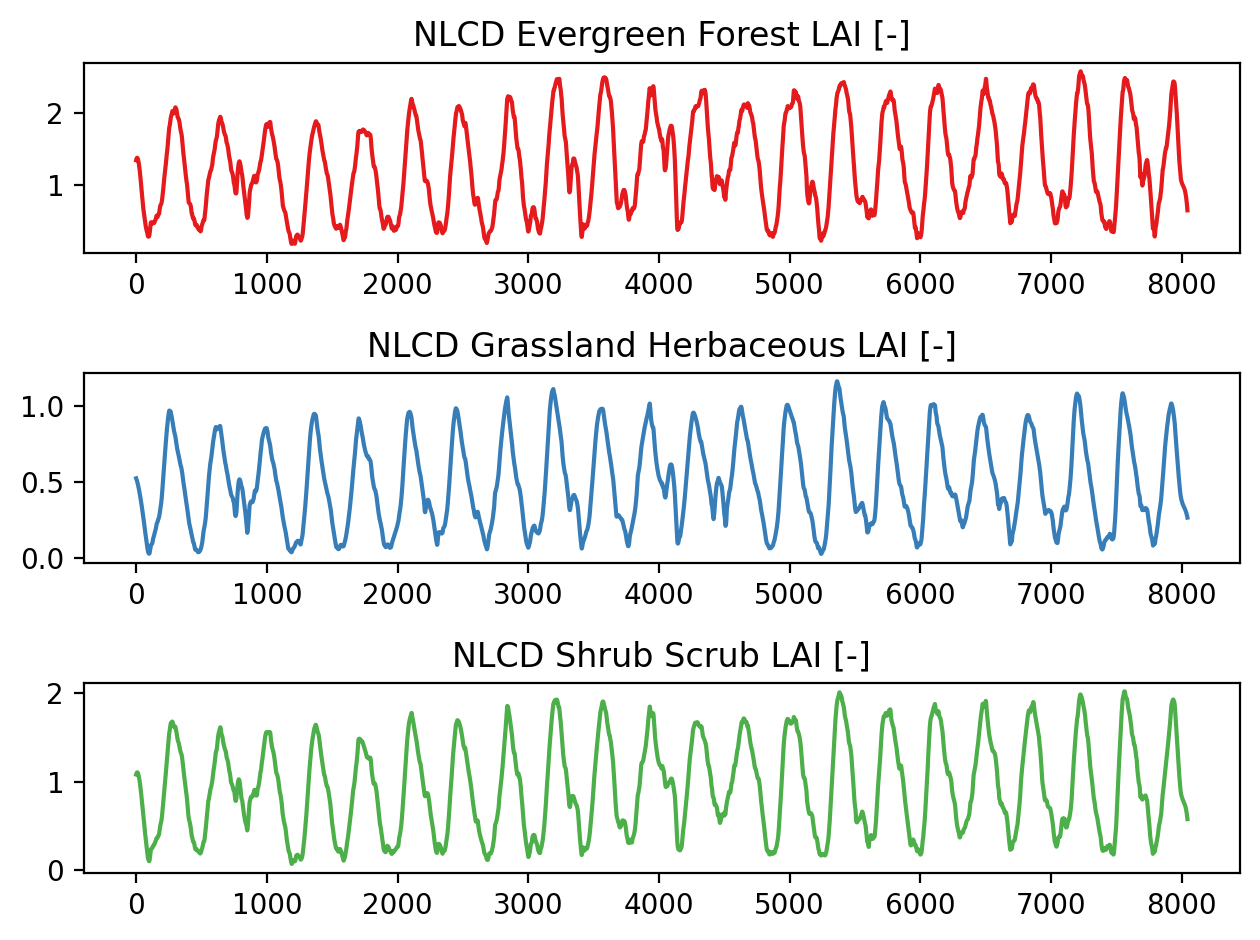

time [d]  NLCD Evergreen Forest LAI [-]  \
0            0                       1.345628   
1            1                       1.354119   
2            2                       1.361324   
3            3                       1.367271   
4            4                       1.371988   
...        ...                            ...   
8040      8040                       0.729907   
8041      8041                       0.710236   
8042      8042                       0.689462   
8043      8043                       0.667546   
8044      8044                       0.644452   

      NLCD Grassland Herbaceous LAI [-]  NLCD Shrub Scrub LAI [-]  
0                              0.522576                  1.082477  
1                              0.520262                  1.088194  
2                              0.517833                  1.093138  
3                              0.515290                  1.097321  
4                              0.512635                  1.100759  
...                                 ...                       ...  
8040                           0.279498                  0.629239  
8041                           0.275727                  0.617883  
8042                           0.271775                  0.605909  
8043                           0.267633                  0.593295  
8044                           0.263294                  0.580017  

[8045 rows x 4 columns]

In [127]:
if generate_modis:
    # smooth the data
    df_smooth = pandas.DataFrame()
    df_smooth['time [d]'] = df['time [d]']
    for k in df.keys():
        if k != 'time [d]':
            df_smooth[k] = scipy.signal.savgol_filter(df[k], 101, 3)

    if generate_plots:
        # plot comparison
        fig = plt.figure()
        axs = fig.subplots(3,1)
        # plot(df, '-', axs)
        plot(df_smooth, '-', axs)
        plt.tight_layout()
        plt.show()
        
        
df_smooth if generate_modis else generate_modis

In [128]:
# add time back and write to disk
outputs['modis_filename'] = f'../data-processed/{name}/{name}_MODIS_LAI_07042002_10152024_smoothed.h5'

if generate_modis:
    df_smooth['time [s]'] = df_smooth['time [d]']*86400
    with h5py.File(outputs['modis_filename'],'w') as fid:
        for k in df_smooth:
            fid.create_dataset(k, data=df_smooth[k][:])

In [129]:
if generate_modis:
    df = df_smooth
    # split into n_years dataframes, one per year
    df_yr = []
    for year in range(20):
        yr = df.loc[df_interp['time [d]'] >= year*365]
        df_yr.append(yr.loc[yr['time [d]'] < (year+1)*365])

    # average across the years
    df_avg = pandas.DataFrame()
    for yr in df_yr:
        for k in yr.keys():
            if not k.startswith('time'):
                if k in df_avg:
                    df_avg[k] = df_avg[k].array + yr[k].array
                else:
                    df_avg[k] = yr[k].copy()

    for k in df_avg.keys():
        df_avg[k] = df_avg[k][:] / len(df_yr)

    df_avg['time [d]'] = df['time [d]']
    
df_avg if generate_modis else generate_modis

NLCD Evergreen Forest LAI [-]  NLCD Grassland Herbaceous LAI [-]  \
0                         1.472395                           0.474694   
1                         1.460056                           0.470732   
2                         1.447661                           0.466693   
3                         1.434903                           0.462522   
4                         1.421821                           0.458232   
..                             ...                                ...   
360                       1.566593                           0.496754   
361                       1.550373                           0.492008   
362                       1.533961                           0.487331   
363                       1.517718                           0.482721   
364                       1.502313                           0.478299   

     NLCD Shrub Scrub LAI [-]  time [d]  
0                    1.094170         0  
1                    1.087559         1  
2                    1.080984         2  
3                    1.074189         3  
4                    1.067201         4  
..                        ...       ...  
360                  1.142495       360  
361                  1.133290       361  
362                  1.124158       362  
363                  1.115183       363  
364                  1.106738       364  

[365 rows x 4 columns]

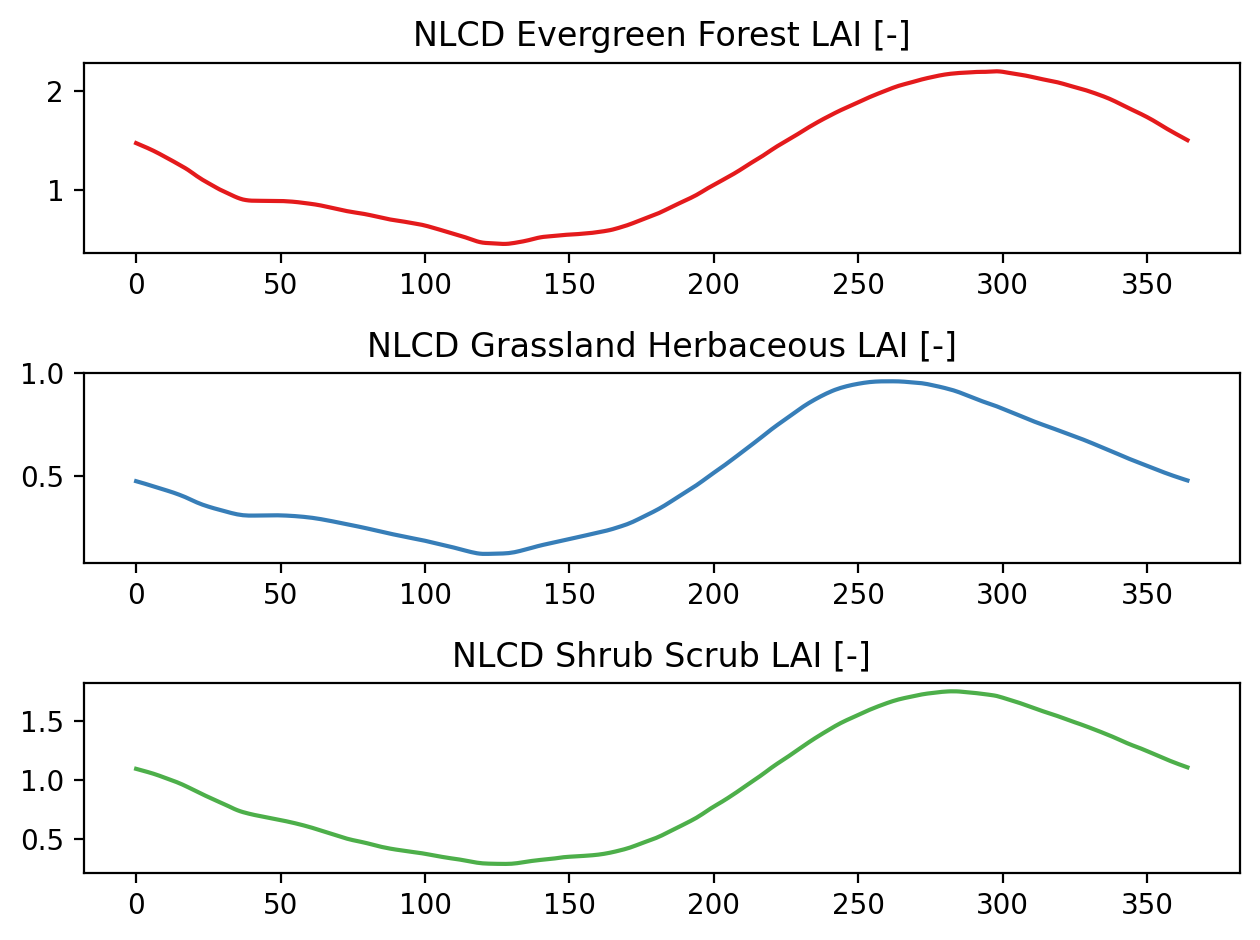

In [130]:
if generate_modis:    
    if generate_plots:
        fig = plt.figure()
        axs = fig.subplots(3,1)
        plot(df_avg, '-', axs)
        plt.tight_layout()
        plt.show()

In [131]:
nyears = 43 # to match DayMet 1980-2022
if generate_modis:
    # replicate nyears times to make nyears years (remem)
    # tile all data to repeat n_year times
    df_repeat = pandas.DataFrame()
    for key in df_avg:
        if not key.startswith('time'):
            df_repeat[key] = np.tile(df_avg[key].array, nyears)
            assert(len(df_repeat) == nyears*365)
    
    # time is simply daily data
    df_repeat['time [d]'] = np.arange(0., nyears * 365., 1.)
    df_repeat['time [s]'] = 86400*df_repeat['time [d]']
    
df_repeat if generate_modis else generate_modis

NLCD Evergreen Forest LAI [-]  NLCD Grassland Herbaceous LAI [-]  \
0                           1.472395                           0.474694   
1                           1.460056                           0.470732   
2                           1.447661                           0.466693   
3                           1.434903                           0.462522   
4                           1.421821                           0.458232   
...                              ...                                ...   
15690                       1.566593                           0.496754   
15691                       1.550373                           0.492008   
15692                       1.533961                           0.487331   
15693                       1.517718                           0.482721   
15694                       1.502313                           0.478299   

       NLCD Shrub Scrub LAI [-]  time [d]      time [s]  
0                      1.094170       0.0  0.000000e+00  
1                      1.087559       1.0  8.640000e+04  
2                      1.080984       2.0  1.728000e+05  
3                      1.074189       3.0  2.592000e+05  
4                      1.067201       4.0  3.456000e+05  
...                         ...       ...           ...  
15690                  1.142495   15690.0  1.355616e+09  
15691                  1.133290   15691.0  1.355702e+09  
15692                  1.124158   15692.0  1.355789e+09  
15693                  1.115183   15693.0  1.355875e+09  
15694                  1.106738   15694.0  1.355962e+09  

[15695 rows x 5 columns]

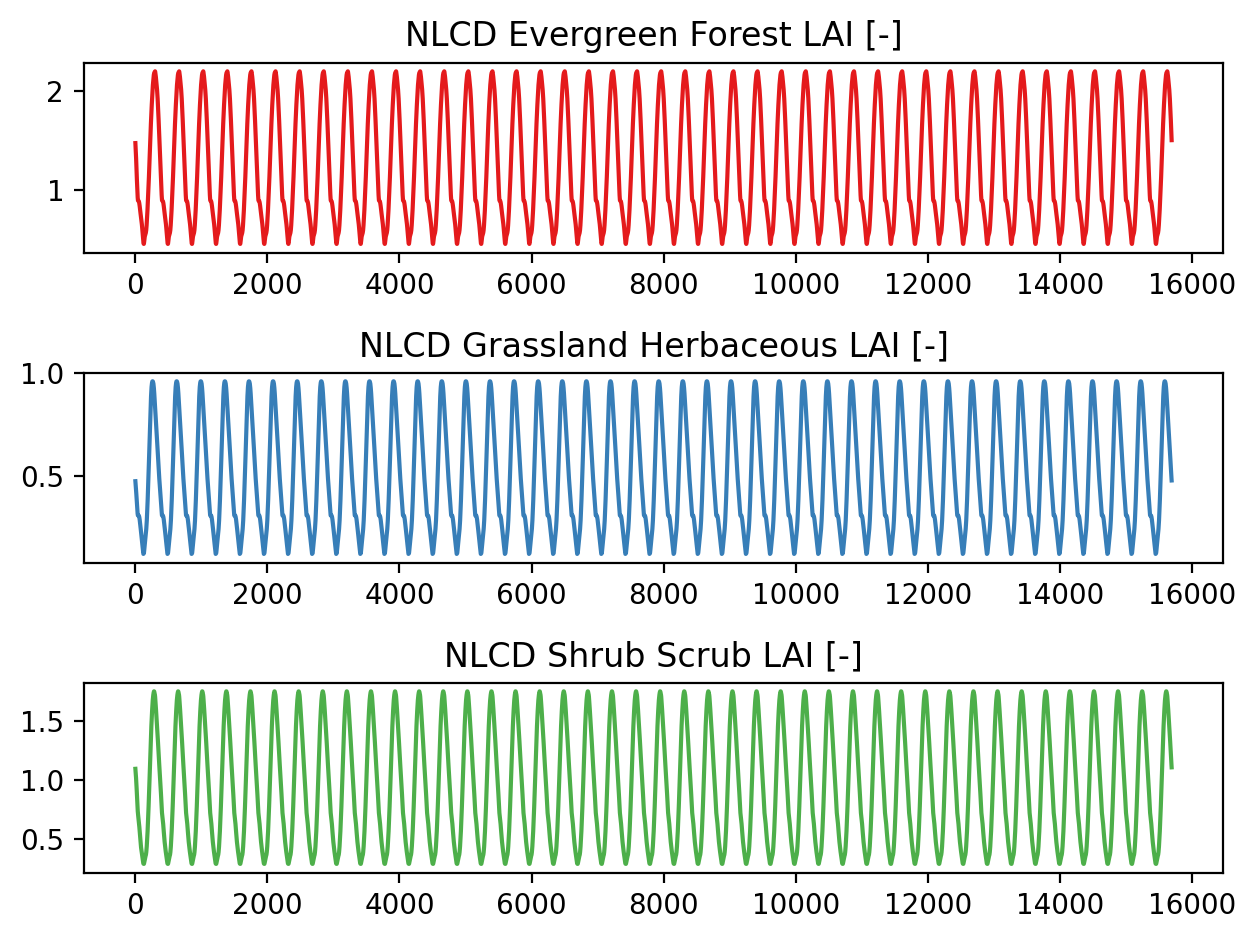

In [132]:
if generate_modis and generate_plots:
    # plot this and make sure it looks right
    fig = plt.figure()
    axs = fig.subplots(3,1)
    plot(df_repeat, '-', axs)
    plt.tight_layout()
    plt.show()

In [133]:
# write to disk
outputs['modis_typical_filename'] = f'../data-processed/{name}/{name}_MODIS_LAI_07042002_10152024_typical{nyears}yr.h5'

if generate_modis:
    with h5py.File(outputs['modis_typical_filename'],'w') as fid:
        for k in df_repeat:
            fid.create_dataset(k, data=df_repeat[k][:])

In [134]:
# add 274 to typical
if generate_modis:
    d = h5py.File(outputs['modis_typical_filename'],'r')
    df = pandas.DataFrame()
    for k in d.keys():
        if k != 'time [d]':
            df[k] = d[k][:]
    d.close()
    df['time [s]'] += 274*86400
    with h5py.File(outputs['modis_typical_filename'],'w') as fid:
        for k in df:
            fid.create_dataset(k, data=df[k][:])
df if generate_modis else generate_modis

NLCD Evergreen Forest LAI [-]  NLCD Grassland Herbaceous LAI [-]  \
0                           1.472395                           0.474694   
1                           1.460056                           0.470732   
2                           1.447661                           0.466693   
3                           1.434903                           0.462522   
4                           1.421821                           0.458232   
...                              ...                                ...   
15690                       1.566593                           0.496754   
15691                       1.550373                           0.492008   
15692                       1.533961                           0.487331   
15693                       1.517718                           0.482721   
15694                       1.502313                           0.478299   

       NLCD Shrub Scrub LAI [-]      time [s]  
0                      1.094170  2.367360e+07  
1                      1.087559  2.376000e+07  
2                      1.080984  2.384640e+07  
3                      1.074189  2.393280e+07  
4                      1.067201  2.401920e+07  
...                         ...           ...  
15690                  1.142495  1.379290e+09  
15691                  1.133290  1.379376e+09  
15692                  1.124158  1.379462e+09  
15693                  1.115183  1.379549e+09  
15694                  1.106738  1.379635e+09  

[15695 rows x 4 columns]

In [135]:
# add 274 to smoothed
if generate_modis:
    d = h5py.File(outputs['modis_filename'],'r')
    df = pandas.DataFrame()
    for k in d.keys():
        if k != 'time [d]':
            df[k] = d[k][:]
    d.close()
    df['time [s]'] += (274+365*22)*86400
    with h5py.File(outputs['modis_filename'],'w') as fid:
        for k in df:
            fid.create_dataset(k, data=df[k][:])
df if generate_modis else generate_modis

NLCD Evergreen Forest LAI [-]  NLCD Grassland Herbaceous LAI [-]  \
0                          1.345628                           0.522576   
1                          1.354119                           0.520262   
2                          1.361324                           0.517833   
3                          1.367271                           0.515290   
4                          1.371988                           0.512635   
...                             ...                                ...   
8040                       0.729907                           0.279498   
8041                       0.710236                           0.275727   
8042                       0.689462                           0.271775   
8043                       0.667546                           0.267633   
8044                       0.644452                           0.263294   

      NLCD Shrub Scrub LAI [-]    time [s]  
0                     1.082477   717465600  
1                     1.088194   717552000  
2                     1.093138   717638400  
3                     1.097321   717724800  
4                     1.100759   717811200  
...                        ...         ...  
8040                  0.629239  1412121600  
8041                  0.617883  1412208000  
8042                  0.605909  1412294400  
8043                  0.593295  1412380800  
8044                  0.580017  1412467200  

[8045 rows x 4 columns]

## Write ATS input files

We now generate three input files -- two for spinup (steadystate solution and cyclic steadystate solution) and one for transient runs.

Steadystate has its own physics, but cyclic steadystate and transient share a common set of physics.  Each have their own met data strategy.

The first step is to generate the sections of xml that will replace parts of the template files.  This is done prior to loading any templates to make clear that these are totally generated from scratch using the ats_input_spec tool.

Note that throughout, we will assume an additional level of folder nesting, e.g. runs will be completed in '../spinup-CoalCreek/run0', meaning that we have to append an extra '../' to the start of all filenames.  This makes it easier to deal with mistakes, continued runs, etc.

In [136]:
# add the subsurface and surface domains
#
# Note this also adds a "computational domain" region to the region list, and a vis spec 
# for "domain"
def add_domains(main_list, mesh_filename, surface_region='surface', snow=True, canopy=True):
    ats_input_spec.public.add_domain(main_list, 
                                 domain_name='domain', 
                                 dimension=3, 
                                 mesh_type='read mesh file',
                                 mesh_args={'file':mesh_filename})
    if surface_region:
        main_list['mesh']['domain']['build columns from set'] = surface_region    
    
        # Note this also adds a "surface domain" region to the region list and a vis spec for 
        # "surface"
        ats_input_spec.public.add_domain(main_list,
                                domain_name='surface',
                                dimension=2,
                                mesh_type='surface',
                                mesh_args={'surface sideset name':'surface'})
    if snow:
        # Add the snow and canopy domains, which are aliases to the surface
        ats_input_spec.public.add_domain(main_list,
                                domain_name='snow',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})
    if canopy:
        ats_input_spec.public.add_domain(main_list,
                                domain_name='canopy',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})


In [137]:
def add_land_cover(main_list):
    # next write a land-cover section for each NLCD type
    for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
        ats_input_spec.public.set_land_cover_default_constants(main_list, nlcd_name)

    land_cover_list = main_list['state']['initial conditions']['land cover types']
    # update some defaults
    # ['Other', 'Deciduous Forest', 'Evergreen Forest', 'Shrub/Scrub']
    # note, these are from the CLM Technical Note v4.5
    #
    # Rooting depth curves from CLM TN 4.5 table 8.3
    #
    # Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
    # curves we are using (ETC -- add paper citation about this topic).  Likely they need
    # to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
    # factor of 10 converts to [Pa]
    #
    # Note, albedo of canopy taken from CLM TN 4.5 table 3.1
    if 42 in nlcd_color_new:
        land_cover_list['Evergreen Forest']['rooting profile alpha [-]'] = 7.0
        land_cover_list['Evergreen Forest']['rooting profile beta [-]'] = 2.0
        land_cover_list['Evergreen Forest']['rooting depth max [m]'] = 10.0
        land_cover_list['Evergreen Forest']['mafic potential at fully closed stomata [Pa]'] = 255000
        land_cover_list['Evergreen Forest']['mafic potential at fully open stomata [Pa]'] = 66000 * .1
        land_cover_list['Evergreen Forest']['albedo of canopy [-]'] = 0.07

    if 41 in nlcd_color_new:
        land_cover_list['Deciduous Forest']['rooting profile alpha [-]'] = 6.0
        land_cover_list['Deciduous Forest']['rooting profile beta [-]'] = 2.0
        land_cover_list['Deciduous Forest']['rooting depth max [m]'] = 10.0
        land_cover_list['Deciduous Forest']['mafic potential at fully closed stomata [Pa]'] = 224000
        land_cover_list['Deciduous Forest']['mafic potential at fully open stomata [Pa]'] = 35000 * .10
        land_cover_list['Deciduous Forest']['albedo of canopy [-]'] = 0.1



In [138]:

# add soil sets: note we need a way to name the set, so we use, e.g. SSURGO-MUKEY.
def soil_set_name(ats_id):
    if ats_id == 999:
        return 'bedrock'
    source = subsurface_props_used.loc[ats_id]['source']
    native_id = subsurface_props_used.loc[ats_id]['native_index']
    if type(native_id) in [tuple,list]:
        native_id = native_id[0]
    return f"{source}-{native_id}"


# get an ATS "main" input spec list -- note, this is a dummy and is not used to write any files yet
def get_main():
    main_list = ats_input_spec.public.get_main()
    flow_pk = ats_input_spec.public.add_leaf_pk(main_list, 'flow', main_list['cycle driver']['PK tree'], 
                                            'richards-spec')

    # add the mesh and all domains
    mesh_filename = os.path.join('.', outputs['mesh_filename'])
    add_domains(main_list, mesh_filename)

    # add labeled sets
    for ls in m3.labeled_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ls.name, ls.setid, mesh_filename, ls.entity)
    for ss in m3.side_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ss.name, ss.setid, mesh_filename, 'FACE')
    
    # add land cover
    add_land_cover(main_list)

    # add soil material ID regions, porosity, permeability, and WRMs
    for ats_id in subsurface_props_used.index:
        props = subsurface_props_used.loc[ats_id]
        set_name = soil_set_name(ats_id)
        
        if props['van Genuchten n [-]'] < 1.5:
            smoothing_interval = 0.01
        else:
            smoothing_interval = 0.0
        
        ats_input_spec.public.add_soil_type(main_list, set_name, ats_id, mesh_filename,
                                            float(props['porosity [-]']),
                                            float(props['permeability [m^2]']), 1.e-7,
                                            float(props['van Genuchten alpha [Pa^-1]']),
                                            float(props['van Genuchten n [-]']),
                                            float(props['residual saturation [-]']),
                                            float(smoothing_interval))
    # print(main_list)  
    # add observations for each subcatchment for transient runs
    ats_input_spec.public.add_observations_water_balance(main_list, "computational domain", 
                                                         "surface domain","external_sides")
    for poly in watershed.polygons():
        region = poly.properties[huc_key]
        ats_input_spec.public.add_observations_water_balance(main_list, region, outlet_region=region+' outlet')
    
    
    return main_list

# create the main list
main_list = get_main()

outputs['generated_ats'] = f'../data-processed/{name}/{name}_generated_ats.xml'
ats_input_spec.io.write(main_list, outputs['generated_ats'])
main_xml = ats_input_spec.io.to_xml(main_list)

/global/cfs/cdirs/m1800/zhi/ww/ats_input_spec/ats_input_spec/io.py:43: UserWarning: Creating an incomplete XML object, missing entries!
  warnings.warn('Creating an incomplete XML object, missing entries!')


In [139]:
def populate_basic_properties(xml, main_xml, homogeneous_wrm=False, homogeneous_poro=False, homogeneous_perm=False):
    """This function updates an xml object with the above properties for mesh, regions, soil props, and lc props"""
    # find and replace the mesh list
    mesh_i = next(i for (i,el) in enumerate(xml) if el.get('name') == 'mesh')
    xml[mesh_i] = asearch.child_by_name(main_xml, 'mesh')

    # find and replace the regions list
    region_i = next(i for (i,el) in enumerate(xml) if el.get('name') == 'regions')
    xml[region_i] = asearch.child_by_name(main_xml, 'regions')

    # find and replace the WRMs list -- note here we only replace the inner "WRM parameters" because the
    # demo has this in the PK, not in the evaluators list
    if not homogeneous_wrm:
        wrm_list = asearch.find_path(xml, ['PKs', 'water retention evaluator'])
        wrm_i = next(i for (i,el) in enumerate(wrm_list) if el.get('name') == 'WRM parameters')
        wrm_list[wrm_i] = asearch.find_path(main_xml, ['PKs','water retention evaluator','WRM parameters'])

    fe_list = asearch.find_path(xml, ['state', 'evaluators'])

    # find and replace porosity, permeability
    if not homogeneous_poro:
        poro_i = next(i for (i,el) in enumerate(fe_list) if el.get('name') == 'base_porosity')
        fe_list[poro_i] = asearch.find_path(main_xml, ['state', 'evaluators', 'base_porosity'])

    if not homogeneous_perm:
        perm_i = next(i for (i,el) in enumerate(fe_list) if el.get('name') == 'permeability')
        fe_list[perm_i] = asearch.find_path(main_xml, ['state', 'evaluators', 'permeability'])

    # find and replace land cover
    consts_list = asearch.find_path(xml, ['state', 'initial conditions'])
    try:
        lc_i = next(i for (i,el) in enumerate(consts_list) if el.get('name') == 'land cover types')
    except StopIteration:
        pass
    else:
        consts_list[lc_i] = asearch.find_path(main_xml, ['state', 'initial conditions', 'land cover types'])

def create_unique_name(name, homogeneous_wrm=False, homogeneous_poro=False, homogeneous_perm=False):
    suffix = '_h'
    if homogeneous_perm:
        suffix += 'K'
    if homogeneous_poro:
        suffix += 'p'
    if homogeneous_wrm:
        suffix += 'w'
    if suffix == '_h':
        suffix = ''
    return name + suffix
        

For the first file, we load a spinup template and write the needed quantities into that file, saving it to the appropriate run directory.  Note there is no DayMet or land cover or LAI properties needed for this run.  The only property that is needed is the domain-averaged, mean annual rainfall rate.  We then take off some for ET (note too wet spins up faster than too dry, so don't take off too much...).

In [140]:
if generate_daymet:
    # calculate the basin-averaged, annual-averaged precip rate
    precip_total = ats_typ['precipitation rain [m s^-1]'] + ats_typ['precipitation snow [m SWE s^-1]']
    mean_precip = precip_total.mean()
else:
    rain = 'precipitation rain [m s^-1]'
    snow = 'precipitation snow [m SWE s^-1]'
    try:
        with h5py.File(outputs['daymet_spinup_filename'], 'r') as fid:
            mean_precip = np.array([fid[rain][ts][:].mean() + fid[snow][ts][:].mean() for ts in fid[rain].keys()]).mean()
    except:
        mean_precip = 5e-8
        
mean_precip = 1.38e-08
logging.info(f'Mean annual precip rate [m s^-1] = {mean_precip}')

NameError: name 'ats_typ' is not defined

In [141]:
mean_precip = 1.38e-08
logging.info(f'Mean annual precip rate [m s^-1] = {mean_precip}')

2024-11-25 22:45:50,372 - root - INFO: Mean annual precip rate [m s^-1] = 1.38e-08


In [142]:
def write_spinup_steadystate(name, mean_precip, **kwargs):
    name = create_unique_name(name, **kwargs)
    logging.info(f'Writing transient: {name}')
    
    # write the spinup xml file
    # load the template file
    xml = aio.fromFile('spinup_steadystate-template.xml')

    # populate basic properties for mesh, regions, and soil properties
    populate_basic_properties(xml, main_xml, **kwargs)

    # set the mean avg source as 60% of mean precip
    precip_el = asearch.find_path(xml, ['state', 'evaluators', 'surface-precipitation', 
                                        'function-constant', 'value'])
    precip_el.setValue(mean_precip * .6)

    # write to disk
    outputs[f'spinup_steadystate_{name}_filename'] = f'../run0-spinup_steadystate/{name}_{meshsize}-{int(np.round(meshsize*factor))}.xml'
    aio.toFile(xml, outputs[f'spinup_steadystate_{name}_filename'])

    # make a run directory
    outputs[f'spinup_steadystate_{name}_rundir'] = f'../run0-spinup_steadystate/{name}-0'
    try:
        os.mkdir(outputs[f'spinup_steadystate_{name}_rundir'])
    except FileExistsError:
        pass

For the second file, we load a transient run template.  This file needs the basics, plus DayMet and LAI as the "typical year data".  Also we set the run directory that will be used for the steadystate run.

For the third file, we load a transient run template as well.  This file needs the basics, DayMet with the actual data, and we choose for this run to use the MODIS typical year.  MODIS is only available for 2002 on, so if we didn't need 1980-2002 we could use the real data, but for this run we want a longer record.

In [143]:
def write_transient(name, cyclic_steadystate=False, start_year=1980, end_year=2022, **kwargs):
    # make a unique name based on options
    name = create_unique_name(name, **kwargs)
    logging.info(f'Writing transient: {name}')

    if cyclic_steadystate:
        prefix = 'spinup_cyclic'
        # start_year = 1980
        # end_year = 2022
        previous = 'spinup_steadystate'
        runnum = 'run1'
    else:
        prefix = 'transient'
        previous = 'spinup_cyclic'
        runnum = 'run2'

    template_filename = f'{prefix}-template.xml'
    
    # write the cyclic spinup xml file
    # load the template file
    xml = aio.fromFile(template_filename)

    # populate basic properties for mesh, regions, and soil properties
    populate_basic_properties(xml, main_xml, **kwargs)

    # update the DayMet filenames
    if cyclic_steadystate:
        daymet_filename = outputs['daymet_spinup_filename']
    else:
        daymet_filename = outputs['daymet_filename']
    for var in ['surface-incoming_shortwave_radiation',
                'surface-precipitation_rain',
                'snow-precipitation',
                'surface-air_temperature',
                'surface-vapor_pressure_air',
                'surface-temperature',
                'canopy-temperature']:
        try:
            par = asearch.find_path(xml, ['state', 'evaluators', var, 'file'])
        except aerrors.MissingXMLError:
            pass
        else:
            par.setValue(os.path.join('.', daymet_filename))

    # update the LAI filenames
    for par in asearch.findall_path(xml, ['canopy-leaf_area_index', 'file']):
        if cyclic_steadystate:
            par.setValue(os.path.join('.', outputs['modis_typical_filename']))
        else:
            par.setValue(os.path.join('.', outputs['modis_filename']))
    
    # update the start and end time -- start at Oct 1 of year 0, end 10 years later
    start_day = 274 + 365*(start_year - 1980)
    par = asearch.find_path(xml, ['cycle driver', 'start time'])
    par.setValue(start_day)

    end_day = 274 + 365*(end_year - 1980)
    par = asearch.find_path(xml, ['cycle driver', 'end time'])
    par.setValue(end_day)
    
    # update the restart filenames
    for var in asearch.findall_path(xml, ['initial condition', 'restart file']):
        var.setValue(os.path.join('.', outputs[f'{previous}_{name}_rundir'], 'checkpoint_final.h5'))

    # update the observations list
    obs = next(i for (i,el) in enumerate(xml) if el.get('name') == 'observations')
    xml[obs] = asearch.child_by_name(main_xml, 'observations')
   
        
    # write to disk and make a directory for running the run
    outputs[f'{prefix}_{name}_filename'] = f'../{runnum}-{prefix}/{name}_{meshsize}-{int(np.round(meshsize*factor))}.xml'
    filename = outputs[f'{prefix}_{name}_filename']

    outputs[f'{prefix}_{name}_rundir'] = f'../{runnum}-{prefix}/{name}-0'
    rundir = outputs[f'{prefix}_{name}_rundir']

    aio.toFile(xml, filename)
    try:
        os.mkdir(rundir)
    except FileExistsError:
        pass


In [144]:
# create the fully-heterogeneous runs
if include_heterogeneous:
    write_spinup_steadystate(name, mean_precip)
    write_transient(name, True)
    write_transient(name, False)

# create homogeneous runs
if include_homogeneous:
    write_spinup_steadystate(name, mean_precip, homogeneous_wrm=True, homogeneous_poro=True, homogeneous_perm=True)
    write_transient(name, True, homogeneous_wrm=True, homogeneous_poro=True, homogeneous_perm=True)
    write_transient(name, False, homogeneous_wrm=True, homogeneous_poro=True, homogeneous_perm=True)
    
if include_homogeneous_wrm:
    write_spinup_steadystate(name, mean_precip, homogeneous_wrm=True, homogeneous_poro=False, homogeneous_perm=False)
    write_transient(name, True, homogeneous_wrm=True, homogeneous_poro=False, homogeneous_perm=False)
    write_transient(name, False, homogeneous_wrm=True, homogeneous_poro=False, homogeneous_perm=False)
    
if include_homogeneous_wrm_porosity:
    write_spinup_steadystate(name, mean_precip, homogeneous_wrm=True, homogeneous_poro=True, homogeneous_perm=False)
    write_transient(name, True, homogeneous_wrm=True, homogeneous_poro=True, homogeneous_perm=False)
    write_transient(name, False, homogeneous_wrm=True, homogeneous_poro=True, homogeneous_perm=False)
    
if include_homogeneous_wrm_permeability:
    write_spinup_steadystate(name, mean_precip, homogeneous_wrm=True, homogeneous_poro=False, homogeneous_perm=True)
    write_transient(name, True, homogeneous_wrm=True, homogeneous_poro=False, homogeneous_perm=True)
    write_transient(name, False, homogeneous_wrm=True, homogeneous_poro=False, homogeneous_perm=True)


2024-11-25 22:45:59,761 - root - INFO: Writing transient: OakMixed
2024-11-25 22:45:59,937 - root - INFO: Writing transient: OakMixed
2024-11-25 22:46:00,000 - root - INFO: Writing transient: OakMixed


In [145]:
logging.info('this workflow is a total success')

2024-11-25 22:46:01,996 - root - INFO: this workflow is a total success
